In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as tf
from torchvision.datasets import CIFAR100

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gc

In [4]:
stat1 = torch.Tensor([0.5071, 0.4865, 0.4409])
stat2 = torch.Tensor([0.2009, 0.1984, 0.2023])
stats = stat1, stat2
stats

train_transforms = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.RandomCrop(32, padding=4, padding_mode='reflect'),
    tf.ToTensor(),
    tf.Normalize(*stats, inplace=True)
])

test_transforms = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(*stats)
])

train_data = CIFAR100(download=True, train=True, root="../data", transform=train_transforms)
test_data = CIFAR100(download=True, train=False, root='../data', transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and
        #we refer to our network with such a bottleneck layer, i.e.,
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

In [6]:
#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments
        #consist of a batch normalization layer and an 1×1
        #convolutional layer followed by a 2×2 average pooling
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        temp = self.down_sample(x)
        return temp

    #outputs
    """
    transition = Transition(8,4)
    example = torch.randn(1,8,32,32)
    transition(example)
    >>>
        x shape torch.Size([1, 8, 32, 32])
        after Transition(x) shape torch.Size([1, 4, 16, 16])"""



<h3><u><b><i>model : DenseNet

In [7]:
#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution
        #with 16 (or twice the growth rate for DenseNet-BC)
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each
        #side of the inputs is zero-padded by one pixel to keep
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear_fully_connected = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        #print('first data', x.shape)
        output = self.conv1(x)
        #print('after first conv', output.shape)
        output = self.features(output)
        #print('after features: all blocks', output.shape)
        output = self.avgpool(output)
        #print('after avgpool(1,1)', output.shape)
        output = output.view(output.size()[0], -1)
        #print('after view(batch_size, -1)', output.shape)
        output = self.linear_fully_connected(output)
        #print('after fully connected layer1', output.shape)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

#I tried to spread whole layers..! I hope It helps you to understand DenseNet structure.

#densenet 121 
#total 121 Layers = (6+12+24+16) * 2 + 3(transition_layer) +1(first_conv) + 1(classifying layer)
    """bn, relu are omitted"""
    #conv1(3, growth_rate * 2) : channel: 3 -> 64
        #data: Tensor([batch, 64, 32, 32])

    #layer1
        #_make_dense_layers(Bottleneck, 64, 6)
        #for index in range(6):
            #block1
            #Bottleneckf(64, 32)
            #in_channels = 64 + 32 = 96
            #block2
            #Bottleneck(96, 32)
            #in_channels = 96 + 32 = 108
            #           ...
            #           ...
            # features has 6 blocks, 13 layers now, inchannels is 64 + 32 * 6 = 256!

        #transition layer Transition(in_channels, out_channels = in_channels * 0.5)
            #data became Tensor([batch, 128, 16, 16])
            #in_channel = 128 

    #layer2
        #_make_dense_layers(Bottleneck, 128, 12)
        #for index in range(12):
            #block1
            #Bottleneckf(128, 32)
            #in_channels = 128 + 32 = 160
            #block2
            #Bottleneck(160, 32)
            #in_channels = 160 + 32 = 192
            #           ...
            #           ...
            # features has 18 blocks 37 layers now, inchannels is 128 + 32 * 12 = 512

        #transition layer Transition(in_channels, out_channels = in_channels * 0.5)
            #data became Tensor([batch, 256, 8, 8])
            #in_channel = 256
    
    #layer3
        #_make_dense_layers(Bottleneck, 256, 24)
        #for index in range(24):
            #block1
            #Bottleneckf(256, 32)
            #in_channels = 256 + 32 = 288
            #           ...
            #           ...
            # features has 42 blocks 85 layers now, inchannels is 256 + 32 * 24 = 1024

        #transition layer Transition(in_channels, out_channels = in_channels * 0.5)
            #data became Tensor([batch, 512, 4, 4])
            #in_channel = 512

    #layer4
        #_make_dense_layers(Bottleneck, 512, 16)
        #for index in range(16):
            #           ...
            #           ...
            # features has 58 blocks 117 layers now, inchannels is 512 + 32 * 16 = 1024

        
            #data became Tensor([batch, 1024, 4, 4])
            #in_channel = 1024

    #nn.AdaptiveAvgPool2d((1, 1))
        #data Tensor([batch, 1024, 1, 1])

    #view(batch_size, -1)
        #data Tensor([batch, 1024 * 4* 4])

    #fully_connected_layer
        #data Tensor([batch, 100])

    #I think model has 118 layers...!! 

<h4><b><u> Test model!!!

In [8]:
model_for_test = densenet121()
example = torch.randn(1, 3, 32, 32)
model_for_test(example)

''' 
densenet 121
'''

"""
first data torch.Size([1, 3, 32, 32])
after first conv torch.Size([1, 64, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 96, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 128, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 160, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 192, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 224, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 256, 32, 32])
after Transition(x) shape torch.Size([1, 128, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 160, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 192, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 224, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 256, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 288, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 320, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 352, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 384, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 416, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 448, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 480, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 512, 16, 16])
after Transition(x) shape torch.Size([1, 256, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 288, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 320, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 352, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 384, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 416, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 448, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 480, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 512, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 544, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 576, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 608, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 640, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 672, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 704, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 736, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 768, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 800, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 832, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 864, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 896, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 928, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 960, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 992, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 1024, 8, 8])
after Transition(x) shape torch.Size([1, 512, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 544, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 576, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 608, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 640, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 672, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 704, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 736, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 768, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 800, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 832, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 864, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 896, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 928, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 960, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 992, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 1024, 4, 4])
after features: all blocks torch.Size([1, 1024, 4, 4])
after avgpool(1,1) torch.Size([1, 1024, 1, 1])
after view(batch_size, -1) torch.Size([1, 1024])
after fully connected layer1 torch.Size([1, 100]) """

'\nfirst data torch.Size([1, 3, 32, 32])\nafter first conv torch.Size([1, 64, 32, 32])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 96, 32, 32])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 128, 32, 32])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 160, 32, 32])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 192, 32, 32])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 224, 32, 32])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 256, 32, 32])\nafter Transition(x) shape torch.Size([1, 128, 16, 16])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 160, 16, 16])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 192, 16, 16])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 224, 16, 16])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 256, 16, 16])\nafter concatenate x and bottleneck(x) shape torch.Size([1, 288, 16, 16])\nafter concatenate x and bottleneck(x) shape

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
def train_model(_model, _epoch, _train_data_loader, _optimizer, _lr_sche, _creterion, _array_cost, _array_accu, _array_lr):
    train_cost_sum = 0
    corrects = 0
    print('----------------train----------------')
    for batch_idx, data in enumerate(_train_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        _optimizer.zero_grad()
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = creterion(prediction, y)
        cost.backward()
        _optimizer.step()
        _lr_sche.step()
        _array_lr.append(get_lr(_optimizer))


        train_cost_sum += cost.item()
        if (batch_idx + 1) % (len(_train_data_loader)//3) == 0:
            train_cost_avg = train_cost_sum / (batch_idx + 1)
            print('Epoch:{:2d}/{} batch_idx:{:3d} Train Cost:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx, train_cost_avg))
    
    #_lr_sche.step()
    accuracy = (corrects / len(train_data))*100
    print('Epoch:{:2d}/{} batch_idx:{:3d} Train Accuracy:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx, accuracy))
    _array_cost.append(train_cost_sum/len(_train_data_loader))
    _array_accu.append(accuracy)
        

In [14]:
def test_model(_model, _epoch, _test_data_loader, _creterion, _array_cost, _array_accu):
    test_cost_avg = 0
    corrects = 0
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        
        #corrects_tenser = (prediction.argmax(1) == y)
        #print('corrects shape', corrects_tenser.shape)
        
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = _creterion(prediction, y)
        test_cost_avg += cost.item()/len(_test_data_loader)

    accuracy = (corrects / len(test_data)) * 100
    print('Epoch:{:2d}/{} Test Cost:{:2.6f} Test Accuracy:{:.4f}'
            .format(_epoch, TRAIN_EPOCHS, test_cost_avg, accuracy))
    _array_cost.append(test_cost_avg)
    _array_accu.append(accuracy)


In [15]:
BATCH_SIZE = 72
train_data_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

In [16]:
print('train data set shape', len(train_data))
print('test data set shape', len(test_data))

for data in train_data_loader:
    x, y = data
    print('x shape', x.shape)
    print('y shape', y.shape)

    break
train_iteration = len(train_data)/BATCH_SIZE

print('data_loader length', len(train_data_loader))

train data set shape 50000
test data set shape 10000
x shape torch.Size([72, 3, 32, 32])
y shape torch.Size([72])
data_loader length 694


----------------train----------------
Epoch: 1/80 batch_idx:230 Train Cost:4.103327
Epoch: 1/80 batch_idx:461 Train Cost:3.874692
Epoch: 1/80 batch_idx:692 Train Cost:3.688360
Epoch: 1/80 batch_idx:693 Train Accuracy:13.390000
----------------test----------------
Epoch: 1/80 Test Cost:3.217662 Test Accuracy:21.1300


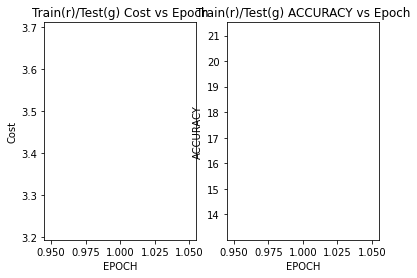

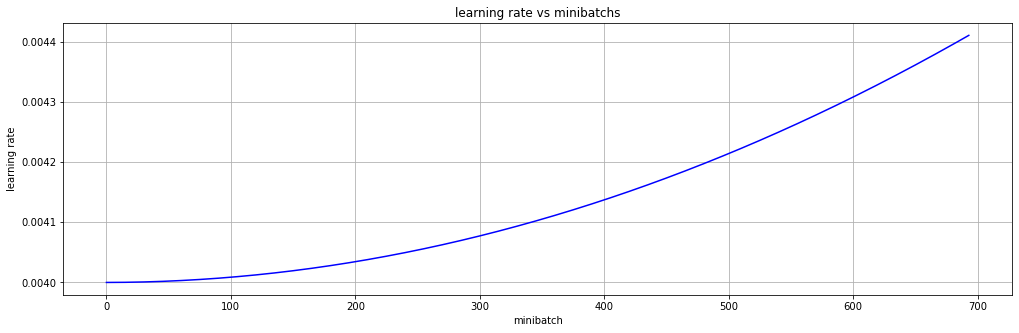

----------------train----------------
Epoch: 2/80 batch_idx:230 Train Cost:3.011505
Epoch: 2/80 batch_idx:461 Train Cost:2.922545
Epoch: 2/80 batch_idx:692 Train Cost:2.825947
Epoch: 2/80 batch_idx:693 Train Accuracy:27.912000
----------------test----------------
Epoch: 2/80 Test Cost:2.543237 Test Accuracy:34.3800


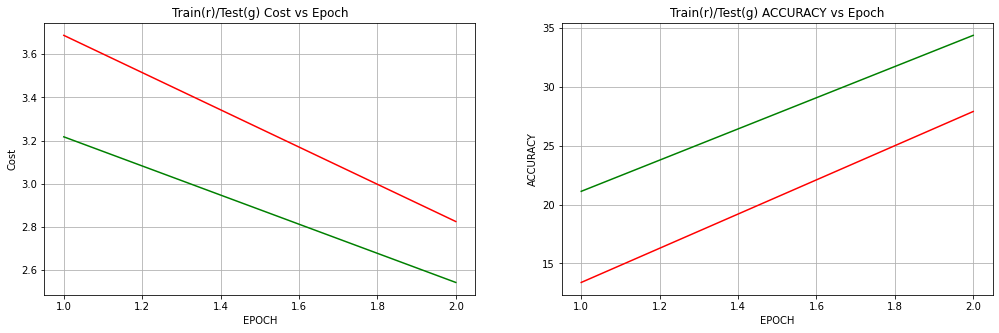

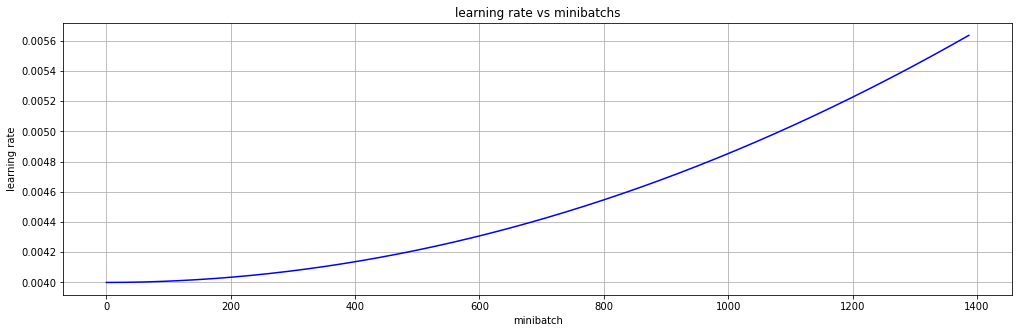

----------------train----------------
Epoch: 3/80 batch_idx:230 Train Cost:2.500797
Epoch: 3/80 batch_idx:461 Train Cost:2.436378
Epoch: 3/80 batch_idx:692 Train Cost:2.373628
Epoch: 3/80 batch_idx:693 Train Accuracy:37.116000
----------------test----------------
Epoch: 3/80 Test Cost:2.416462 Test Accuracy:38.2600


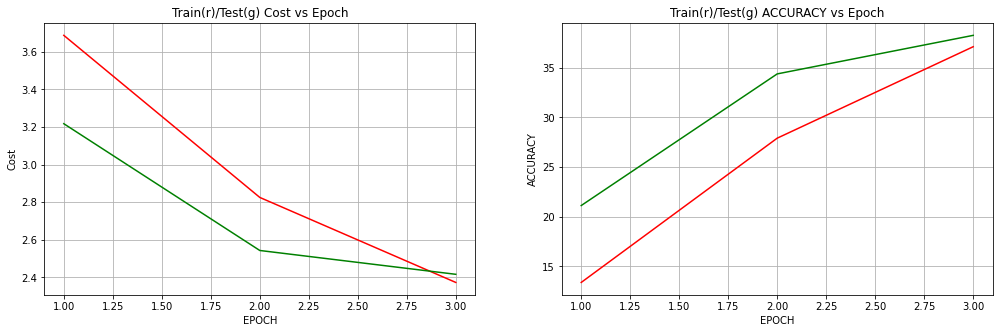

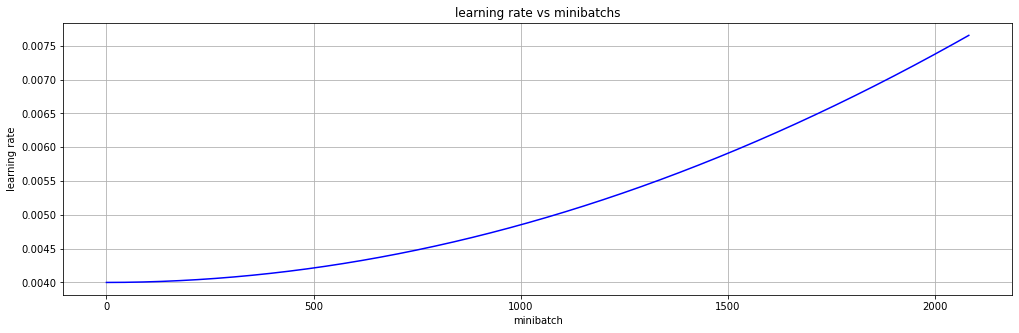

----------------train----------------
Epoch: 4/80 batch_idx:230 Train Cost:2.130471
Epoch: 4/80 batch_idx:461 Train Cost:2.090380
Epoch: 4/80 batch_idx:692 Train Cost:2.067096
Epoch: 4/80 batch_idx:693 Train Accuracy:43.728000
----------------test----------------
Epoch: 4/80 Test Cost:2.204406 Test Accuracy:41.9700


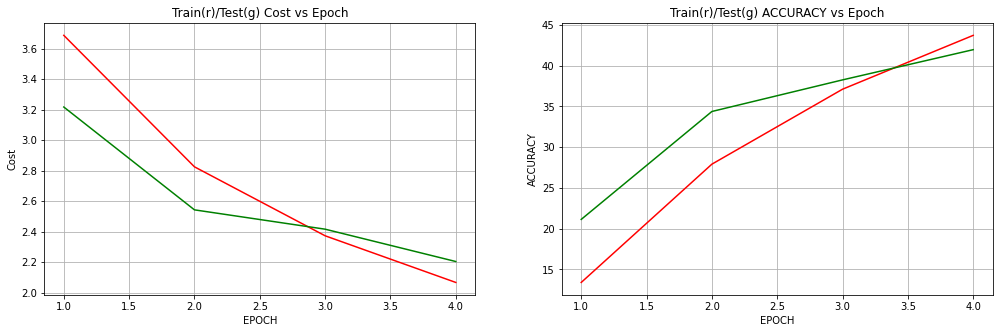

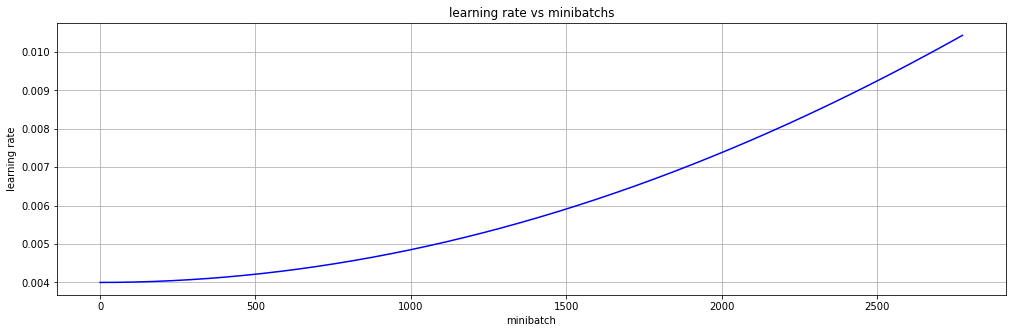

----------------train----------------
Epoch: 5/80 batch_idx:230 Train Cost:1.878855
Epoch: 5/80 batch_idx:461 Train Cost:1.859827
Epoch: 5/80 batch_idx:692 Train Cost:1.841853
Epoch: 5/80 batch_idx:693 Train Accuracy:48.916000
----------------test----------------
Epoch: 5/80 Test Cost:1.888562 Test Accuracy:48.5400


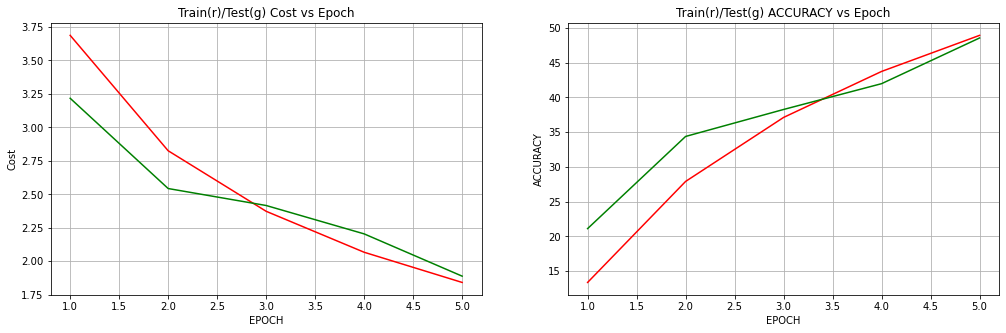

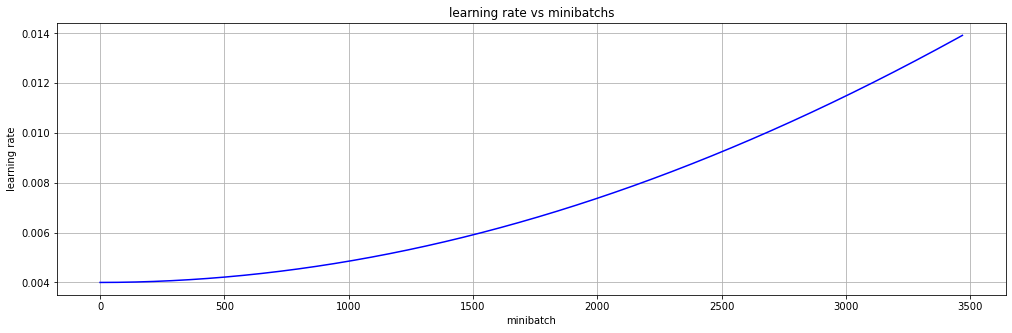

----------------train----------------
Epoch: 6/80 batch_idx:230 Train Cost:1.701610
Epoch: 6/80 batch_idx:461 Train Cost:1.694486
Epoch: 6/80 batch_idx:692 Train Cost:1.690302
Epoch: 6/80 batch_idx:693 Train Accuracy:52.750000
----------------test----------------
Epoch: 6/80 Test Cost:1.819373 Test Accuracy:51.8800


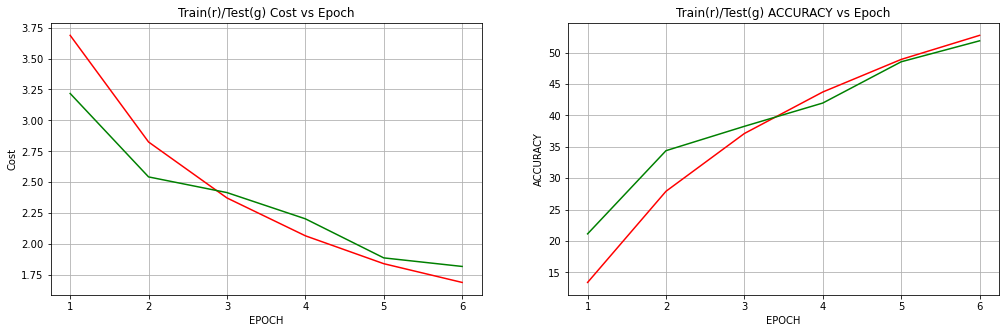

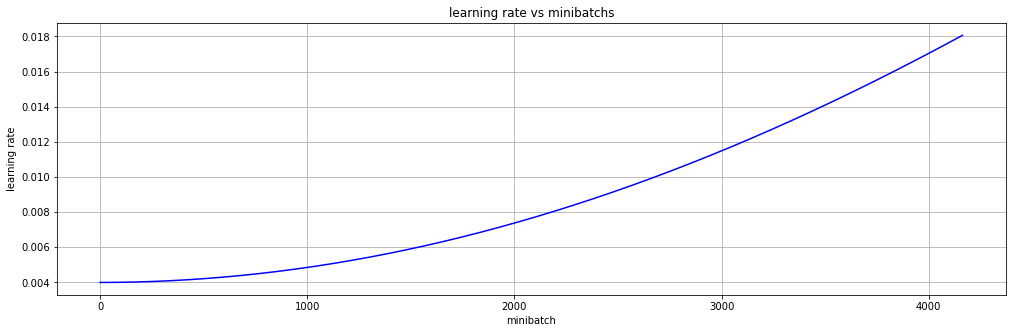

----------------train----------------
Epoch: 7/80 batch_idx:230 Train Cost:1.541504
Epoch: 7/80 batch_idx:461 Train Cost:1.555792
Epoch: 7/80 batch_idx:692 Train Cost:1.542948
Epoch: 7/80 batch_idx:693 Train Accuracy:56.214000
----------------test----------------
Epoch: 7/80 Test Cost:1.737021 Test Accuracy:53.5800


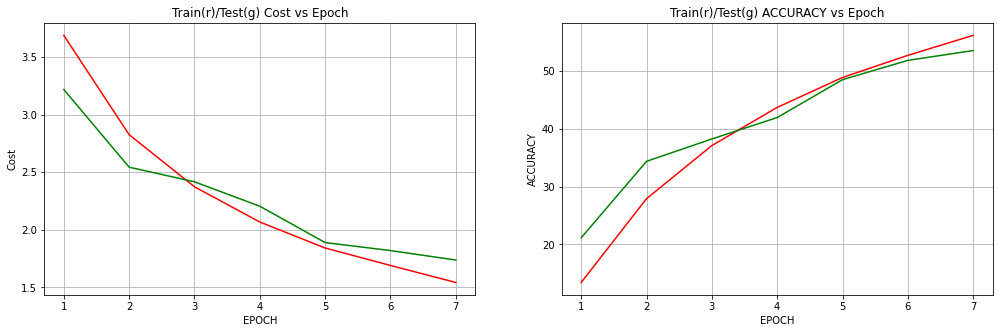

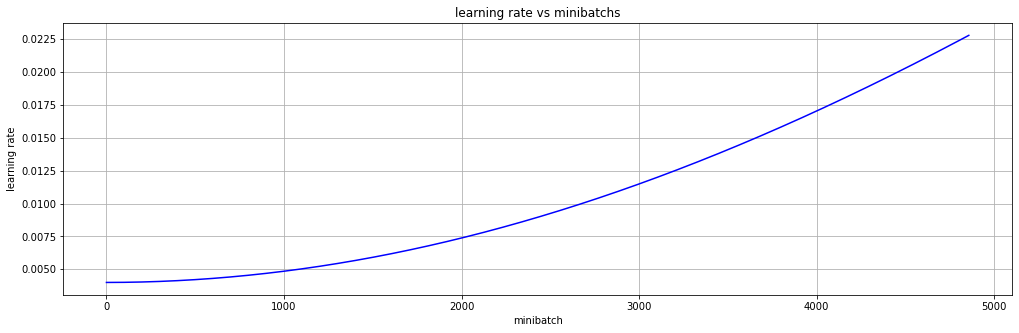

----------------train----------------
Epoch: 8/80 batch_idx:230 Train Cost:1.431236
Epoch: 8/80 batch_idx:461 Train Cost:1.419684
Epoch: 8/80 batch_idx:692 Train Cost:1.426889
Epoch: 8/80 batch_idx:693 Train Accuracy:59.106000
----------------test----------------
Epoch: 8/80 Test Cost:1.578835 Test Accuracy:56.9500


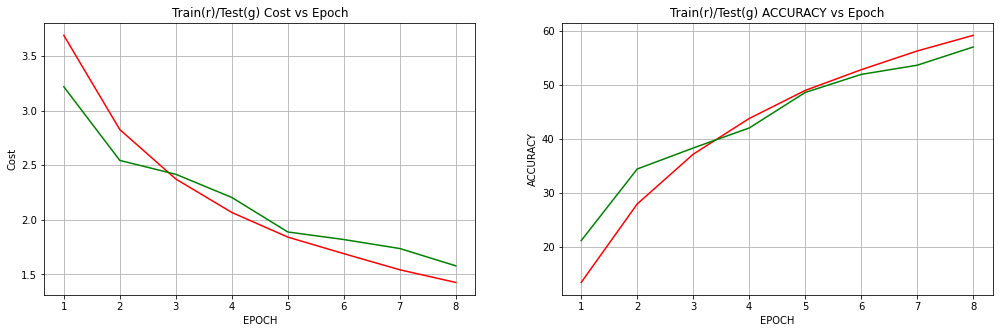

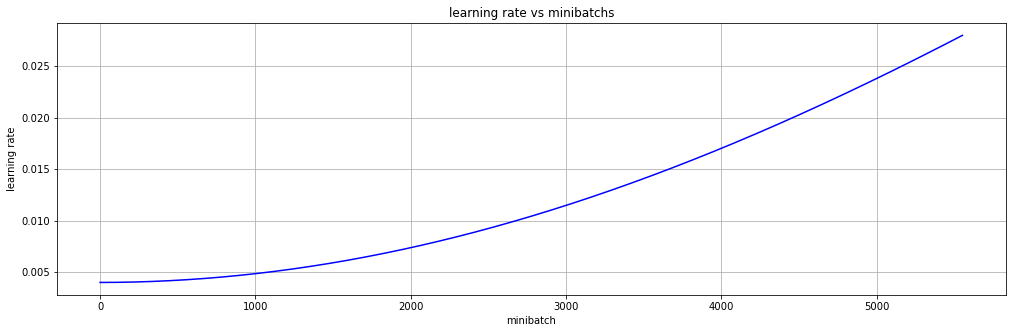

----------------train----------------
Epoch: 9/80 batch_idx:230 Train Cost:1.297635
Epoch: 9/80 batch_idx:461 Train Cost:1.306494
Epoch: 9/80 batch_idx:692 Train Cost:1.306237
Epoch: 9/80 batch_idx:693 Train Accuracy:62.052000
----------------test----------------
Epoch: 9/80 Test Cost:1.772286 Test Accuracy:55.0700


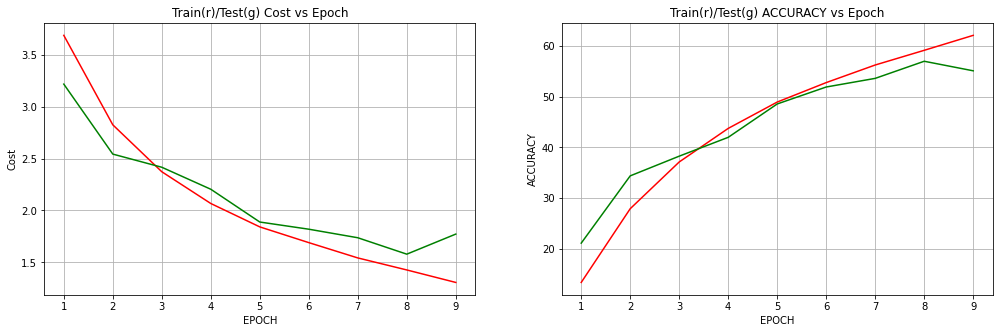

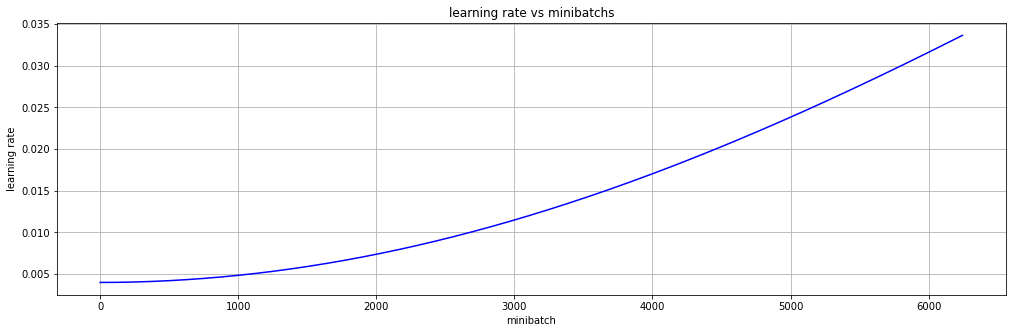

----------------train----------------
Epoch:10/80 batch_idx:230 Train Cost:1.178508
Epoch:10/80 batch_idx:461 Train Cost:1.196360
Epoch:10/80 batch_idx:692 Train Cost:1.199043
Epoch:10/80 batch_idx:693 Train Accuracy:64.924000
----------------test----------------
Epoch:10/80 Test Cost:1.437657 Test Accuracy:59.9100


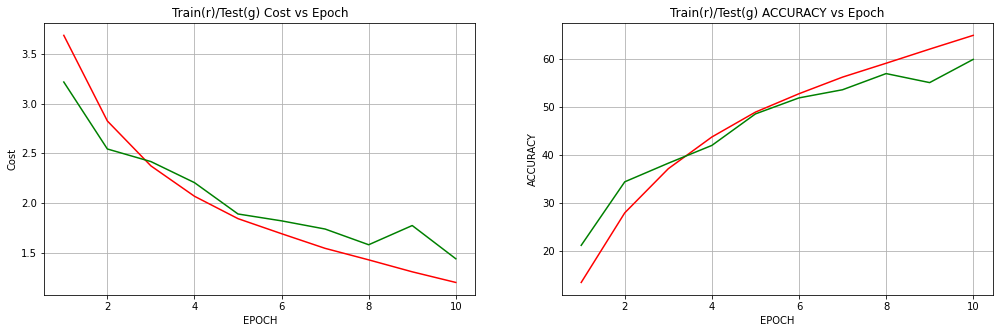

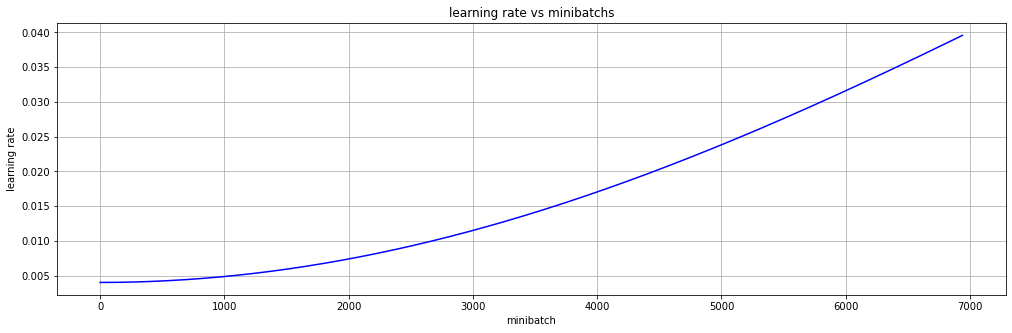

----------------train----------------
Epoch:11/80 batch_idx:230 Train Cost:1.071321
Epoch:11/80 batch_idx:461 Train Cost:1.087831
Epoch:11/80 batch_idx:692 Train Cost:1.094314
Epoch:11/80 batch_idx:693 Train Accuracy:67.560000
----------------test----------------
Epoch:11/80 Test Cost:1.346209 Test Accuracy:62.6600


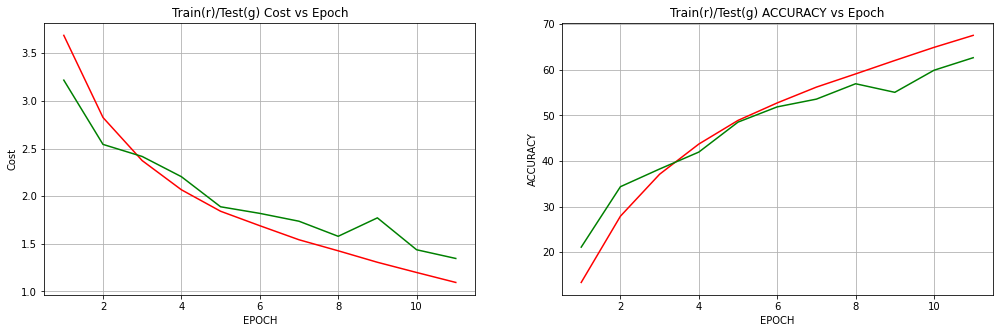

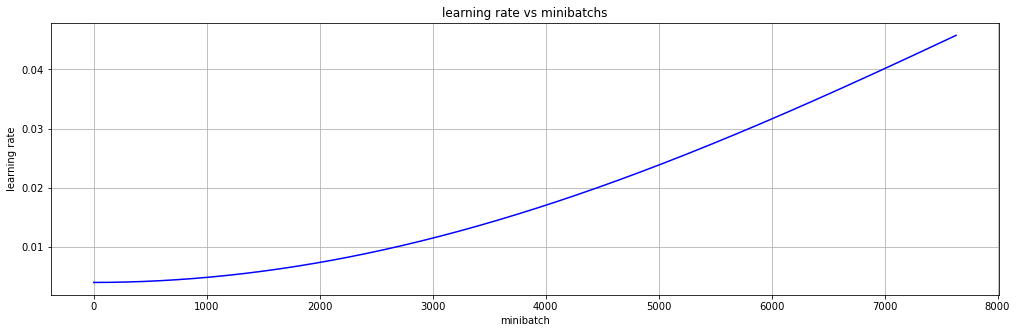

----------------train----------------
Epoch:12/80 batch_idx:230 Train Cost:0.983422
Epoch:12/80 batch_idx:461 Train Cost:1.001115
Epoch:12/80 batch_idx:692 Train Cost:1.010232
Epoch:12/80 batch_idx:693 Train Accuracy:69.816000
----------------test----------------
Epoch:12/80 Test Cost:1.310993 Test Accuracy:64.3300


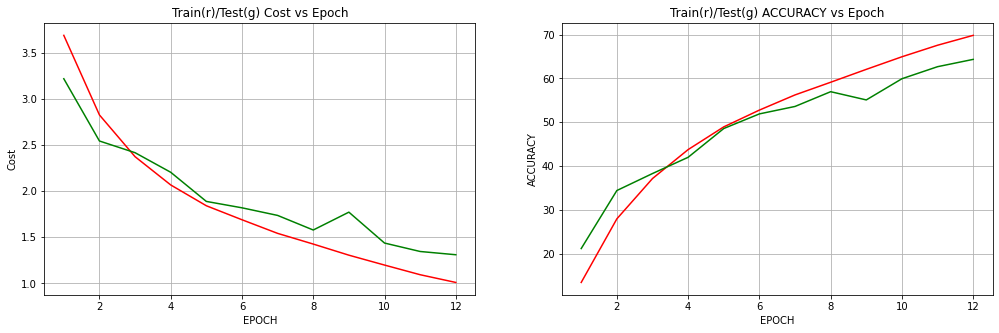

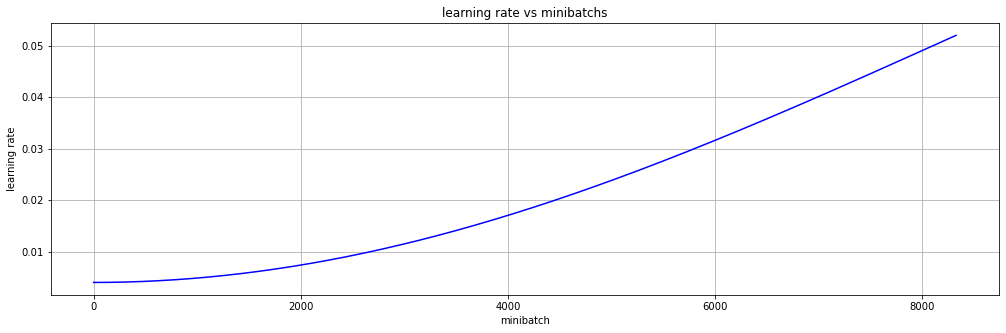

----------------train----------------
Epoch:13/80 batch_idx:230 Train Cost:0.893733
Epoch:13/80 batch_idx:461 Train Cost:0.934722
Epoch:13/80 batch_idx:692 Train Cost:0.940484
Epoch:13/80 batch_idx:693 Train Accuracy:71.752000
----------------test----------------
Epoch:13/80 Test Cost:1.360085 Test Accuracy:63.8700


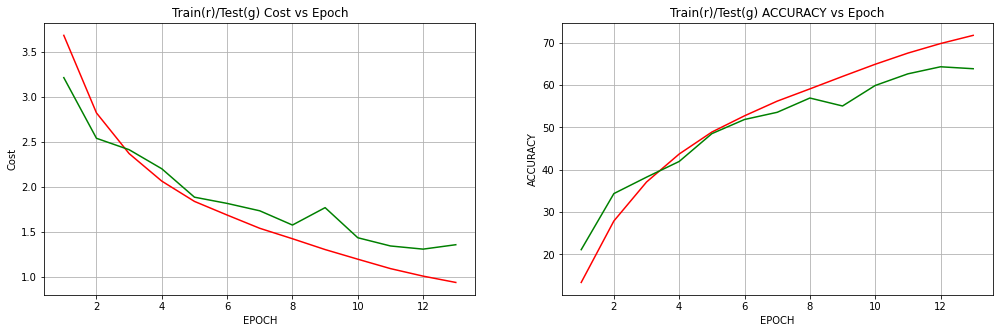

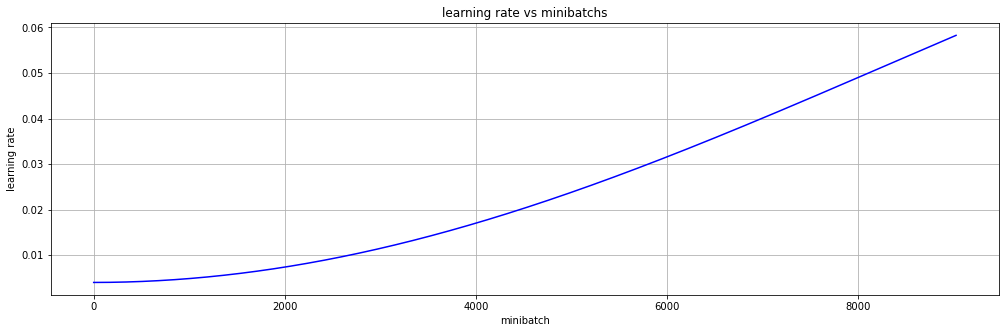

----------------train----------------
Epoch:14/80 batch_idx:230 Train Cost:0.829315
Epoch:14/80 batch_idx:461 Train Cost:0.851214
Epoch:14/80 batch_idx:692 Train Cost:0.861311
Epoch:14/80 batch_idx:693 Train Accuracy:73.896000
----------------test----------------
Epoch:14/80 Test Cost:1.334707 Test Accuracy:63.5500


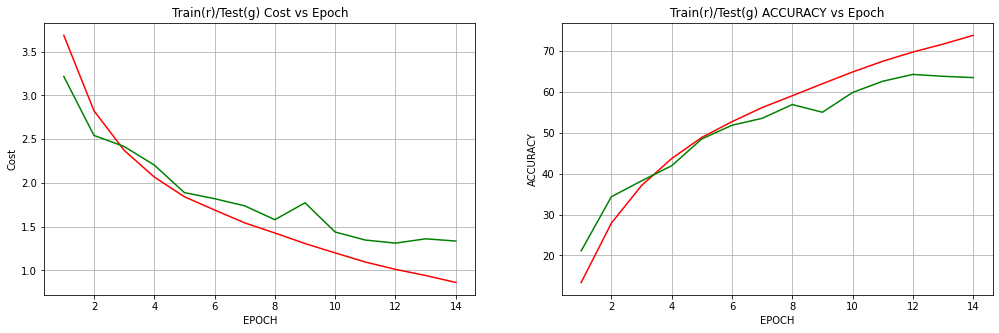

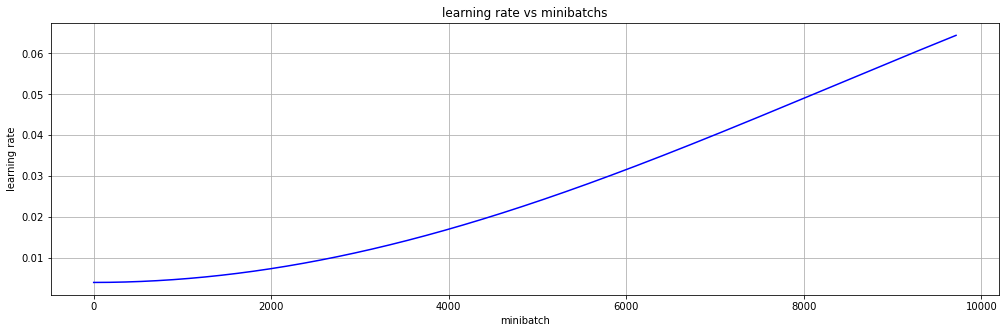

----------------train----------------
Epoch:15/80 batch_idx:230 Train Cost:0.752551
Epoch:15/80 batch_idx:461 Train Cost:0.774201
Epoch:15/80 batch_idx:692 Train Cost:0.796018
Epoch:15/80 batch_idx:693 Train Accuracy:75.706000
----------------test----------------
Epoch:15/80 Test Cost:1.225312 Test Accuracy:66.9300


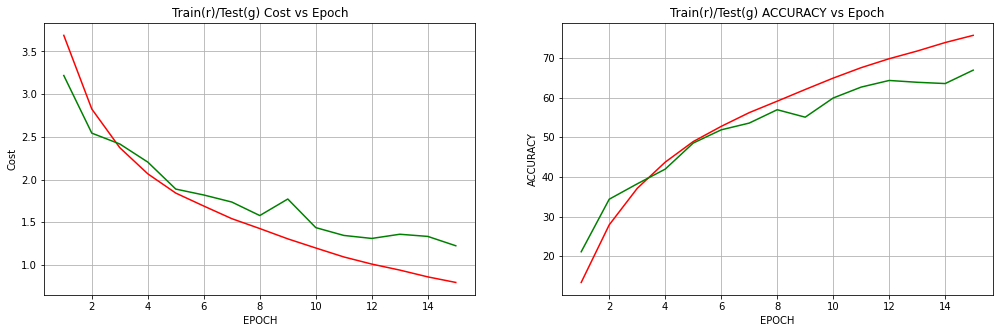

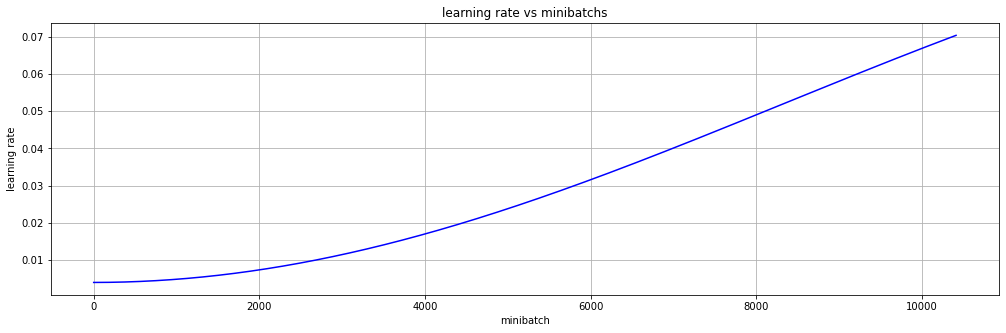

----------------train----------------
Epoch:16/80 batch_idx:230 Train Cost:0.686036
Epoch:16/80 batch_idx:461 Train Cost:0.709085
Epoch:16/80 batch_idx:692 Train Cost:0.723004
Epoch:16/80 batch_idx:693 Train Accuracy:77.604000
----------------test----------------
Epoch:16/80 Test Cost:1.265826 Test Accuracy:66.2100


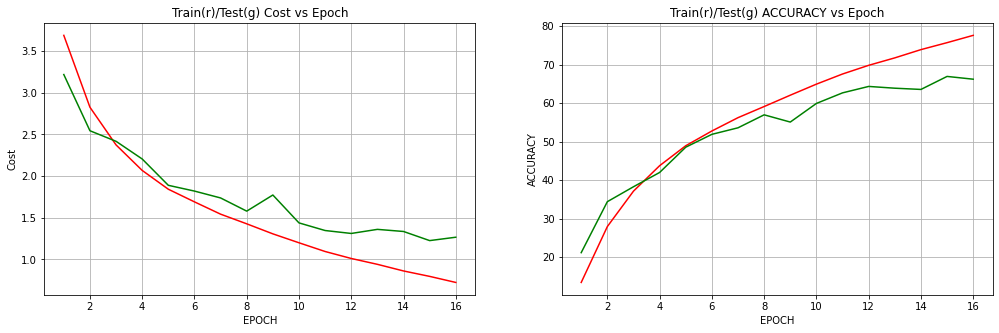

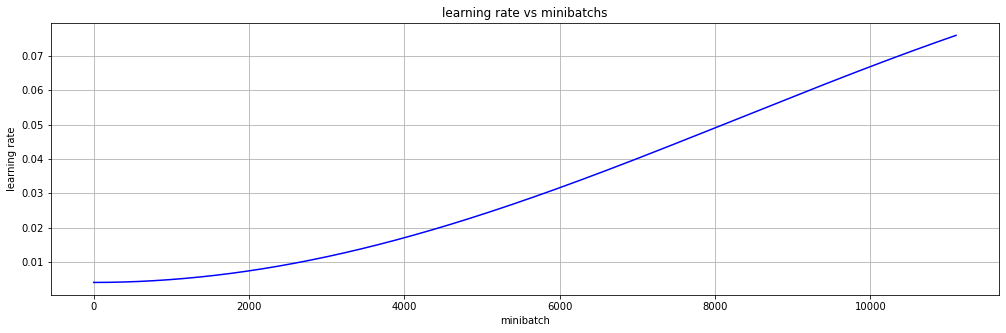

----------------train----------------
Epoch:17/80 batch_idx:230 Train Cost:0.652010
Epoch:17/80 batch_idx:461 Train Cost:0.667038
Epoch:17/80 batch_idx:692 Train Cost:0.674543
Epoch:17/80 batch_idx:693 Train Accuracy:78.954000
----------------test----------------
Epoch:17/80 Test Cost:1.222297 Test Accuracy:67.5000


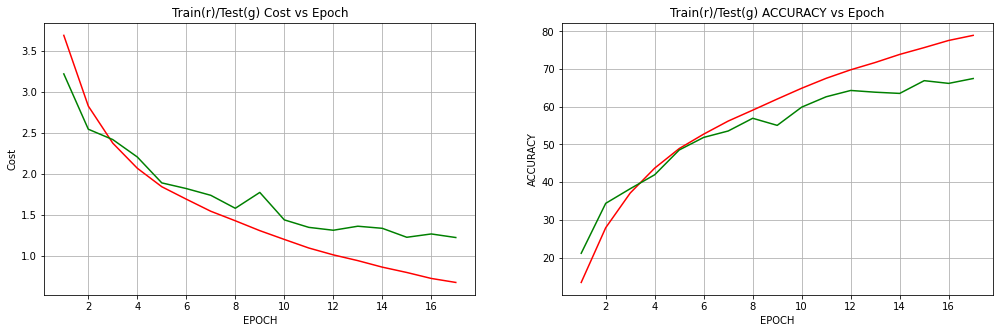

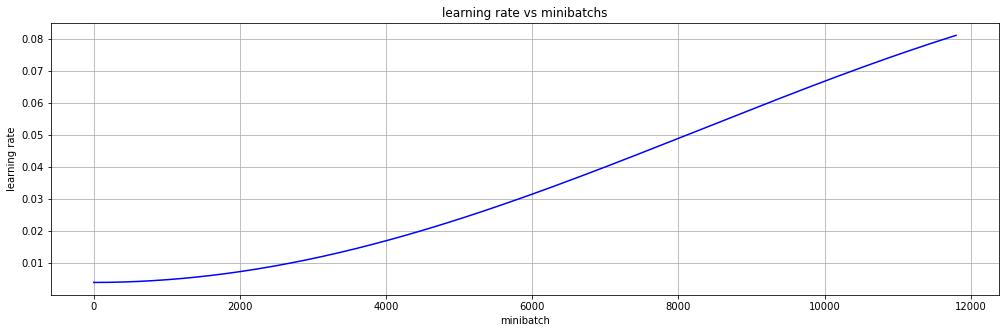

----------------train----------------
Epoch:18/80 batch_idx:230 Train Cost:0.580729
Epoch:18/80 batch_idx:461 Train Cost:0.595854
Epoch:18/80 batch_idx:692 Train Cost:0.619966
Epoch:18/80 batch_idx:693 Train Accuracy:80.676000
----------------test----------------
Epoch:18/80 Test Cost:1.176045 Test Accuracy:69.0100


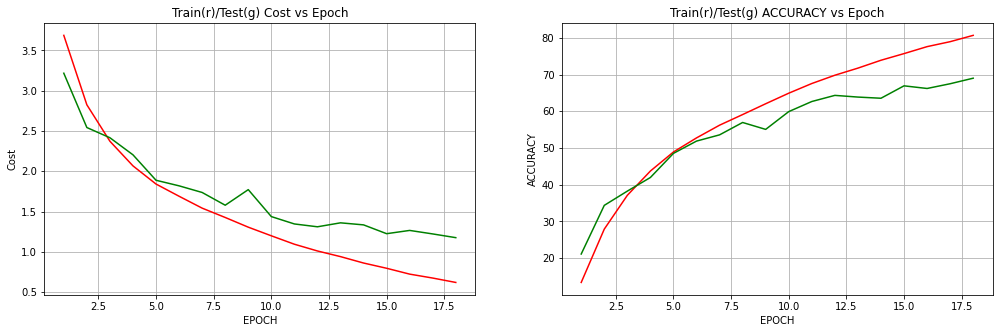

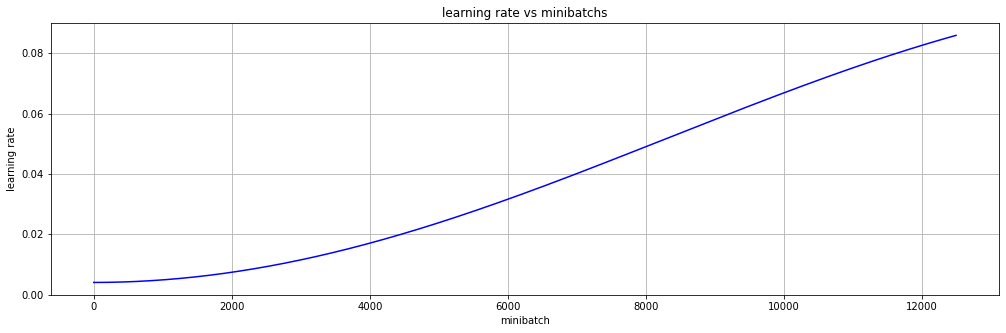

----------------train----------------
Epoch:19/80 batch_idx:230 Train Cost:0.518533
Epoch:19/80 batch_idx:461 Train Cost:0.560166
Epoch:19/80 batch_idx:692 Train Cost:0.573984
Epoch:19/80 batch_idx:693 Train Accuracy:81.974000
----------------test----------------
Epoch:19/80 Test Cost:1.137201 Test Accuracy:69.5100


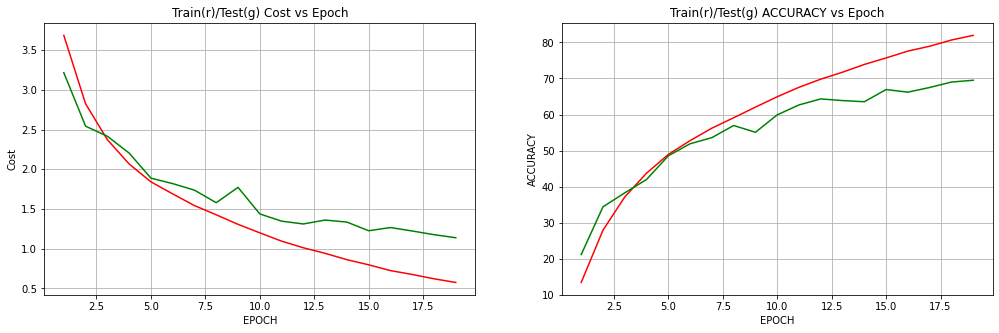

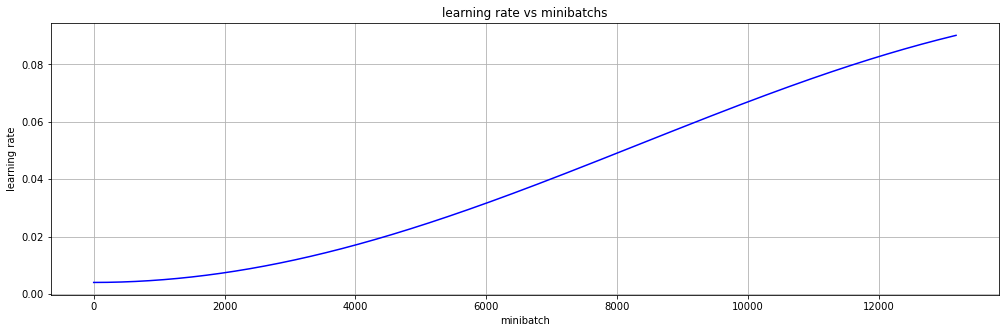

----------------train----------------
Epoch:20/80 batch_idx:230 Train Cost:0.478050
Epoch:20/80 batch_idx:461 Train Cost:0.503477
Epoch:20/80 batch_idx:692 Train Cost:0.518227
Epoch:20/80 batch_idx:693 Train Accuracy:83.620000
----------------test----------------
Epoch:20/80 Test Cost:1.296718 Test Accuracy:67.1600


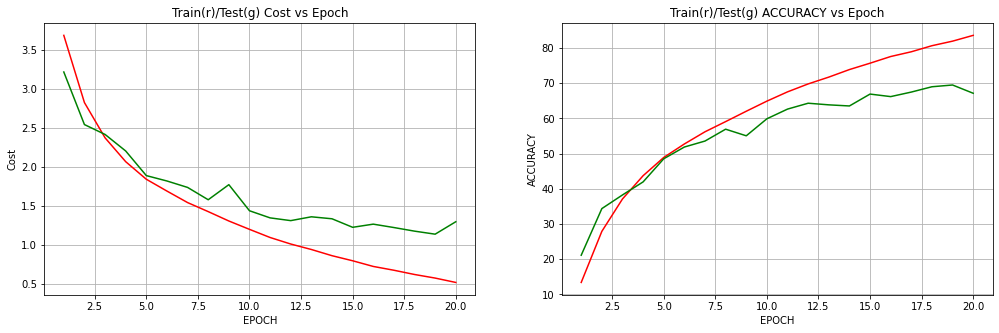

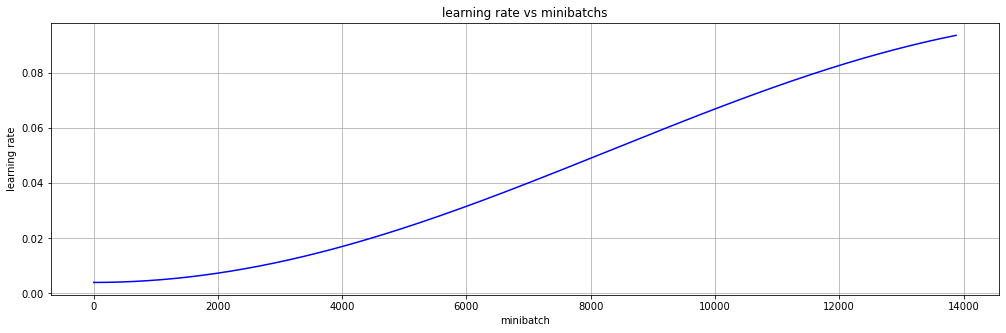

----------------train----------------
Epoch:21/80 batch_idx:230 Train Cost:0.420539
Epoch:21/80 batch_idx:461 Train Cost:0.453716
Epoch:21/80 batch_idx:692 Train Cost:0.475944
Epoch:21/80 batch_idx:693 Train Accuracy:84.736000
----------------test----------------
Epoch:21/80 Test Cost:1.350075 Test Accuracy:68.0400


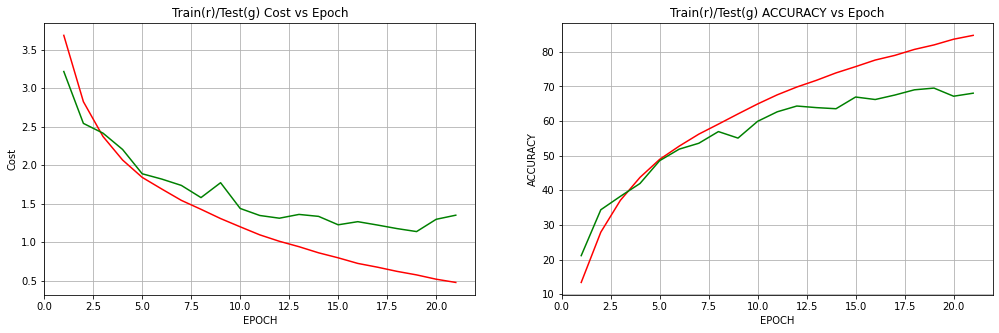

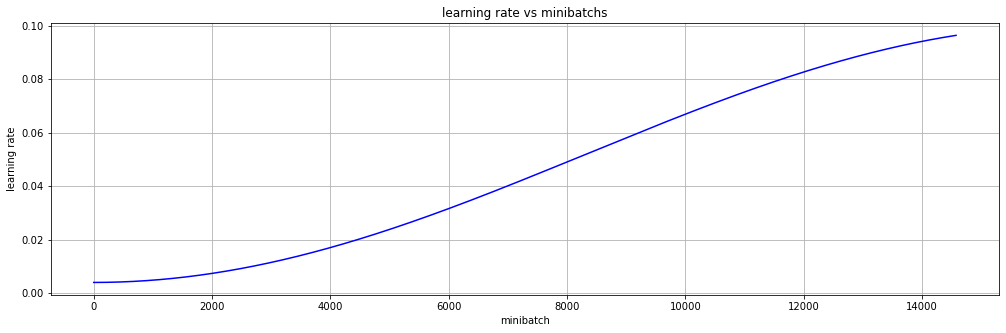

----------------train----------------
Epoch:22/80 batch_idx:230 Train Cost:0.379559
Epoch:22/80 batch_idx:461 Train Cost:0.409202
Epoch:22/80 batch_idx:692 Train Cost:0.432079
Epoch:22/80 batch_idx:693 Train Accuracy:86.070000
----------------test----------------
Epoch:22/80 Test Cost:1.235710 Test Accuracy:69.9500


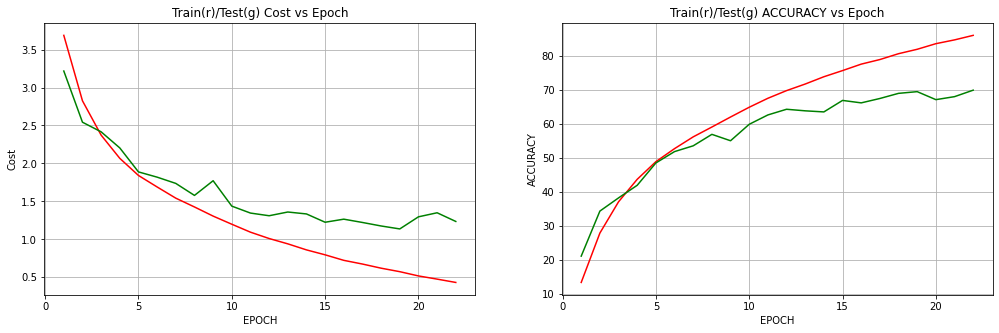

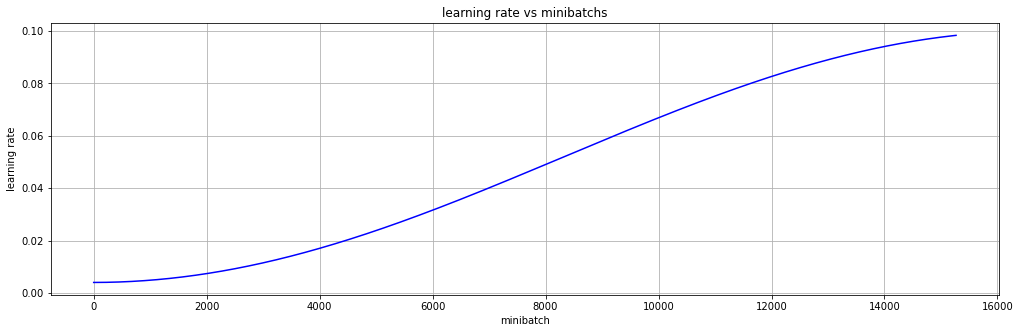

----------------train----------------
Epoch:23/80 batch_idx:230 Train Cost:0.354316
Epoch:23/80 batch_idx:461 Train Cost:0.375374
Epoch:23/80 batch_idx:692 Train Cost:0.393586
Epoch:23/80 batch_idx:693 Train Accuracy:87.050000
----------------test----------------
Epoch:23/80 Test Cost:1.190677 Test Accuracy:71.2400


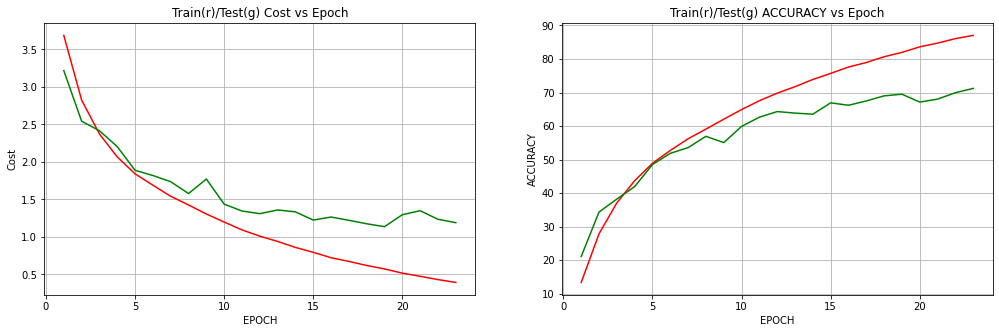

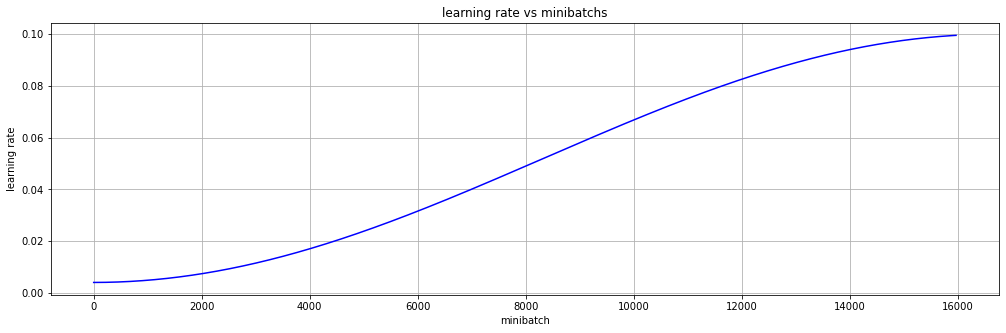

----------------train----------------
Epoch:24/80 batch_idx:230 Train Cost:0.310505
Epoch:24/80 batch_idx:461 Train Cost:0.335068
Epoch:24/80 batch_idx:692 Train Cost:0.351153
Epoch:24/80 batch_idx:693 Train Accuracy:88.438000
----------------test----------------
Epoch:24/80 Test Cost:1.287406 Test Accuracy:70.2800


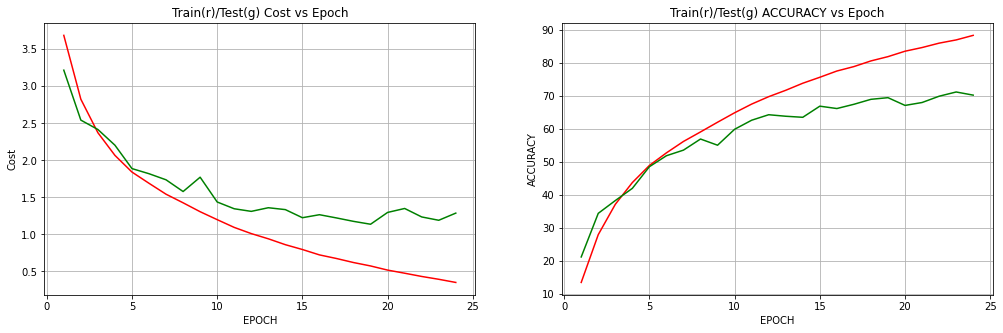

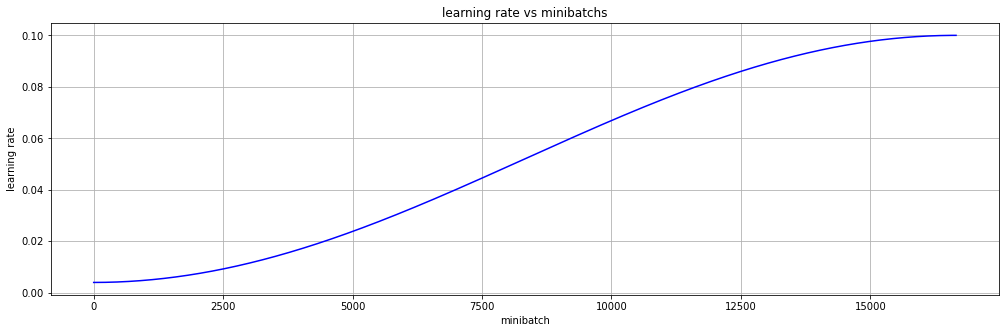

----------------train----------------
Epoch:25/80 batch_idx:230 Train Cost:0.274119
Epoch:25/80 batch_idx:461 Train Cost:0.295580
Epoch:25/80 batch_idx:692 Train Cost:0.317872
Epoch:25/80 batch_idx:693 Train Accuracy:89.440000
----------------test----------------
Epoch:25/80 Test Cost:1.162143 Test Accuracy:72.0400


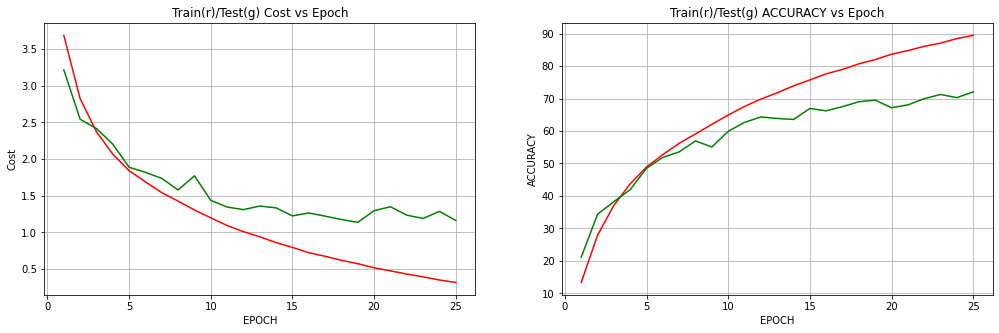

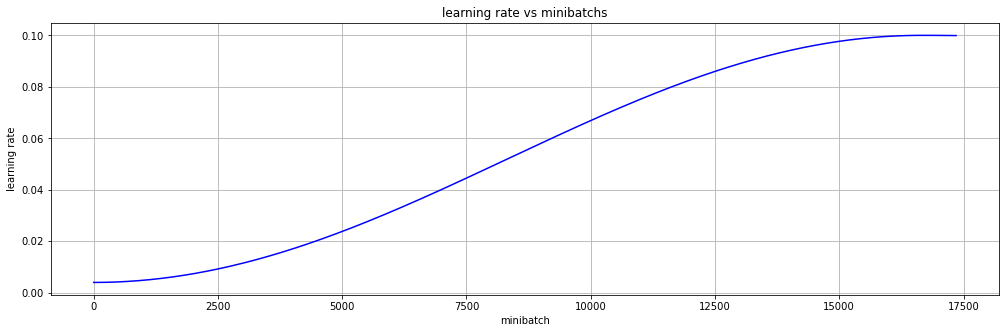

----------------train----------------
Epoch:26/80 batch_idx:230 Train Cost:0.251905
Epoch:26/80 batch_idx:461 Train Cost:0.268070
Epoch:26/80 batch_idx:692 Train Cost:0.282243
Epoch:26/80 batch_idx:693 Train Accuracy:90.546000
----------------test----------------
Epoch:26/80 Test Cost:1.311893 Test Accuracy:70.7600


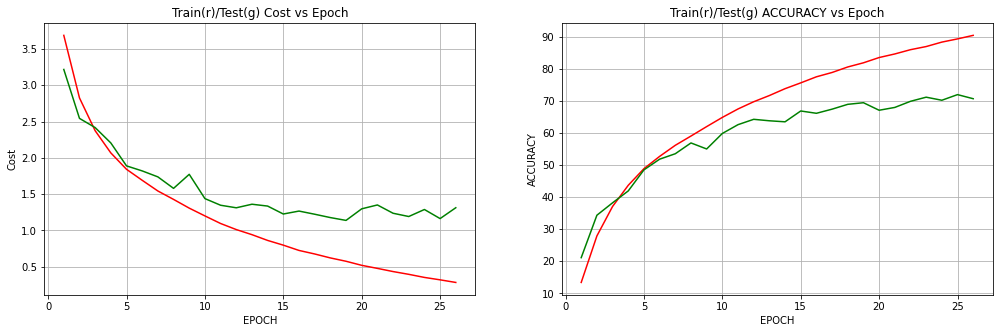

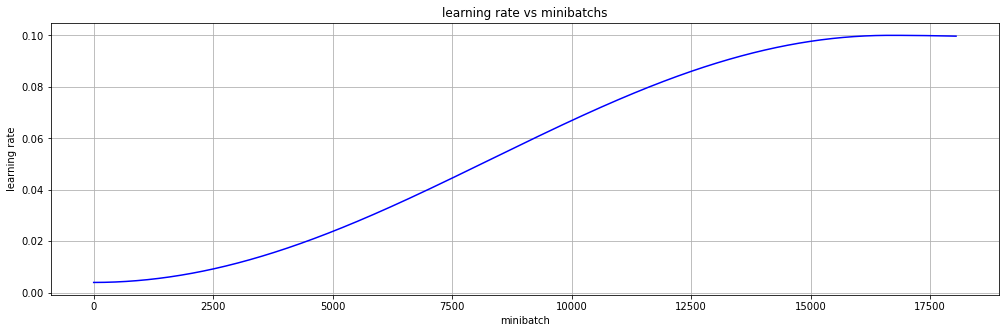

----------------train----------------
Epoch:27/80 batch_idx:230 Train Cost:0.223775
Epoch:27/80 batch_idx:461 Train Cost:0.230410
Epoch:27/80 batch_idx:692 Train Cost:0.252275
Epoch:27/80 batch_idx:693 Train Accuracy:91.532000
----------------test----------------
Epoch:27/80 Test Cost:1.389359 Test Accuracy:70.1100


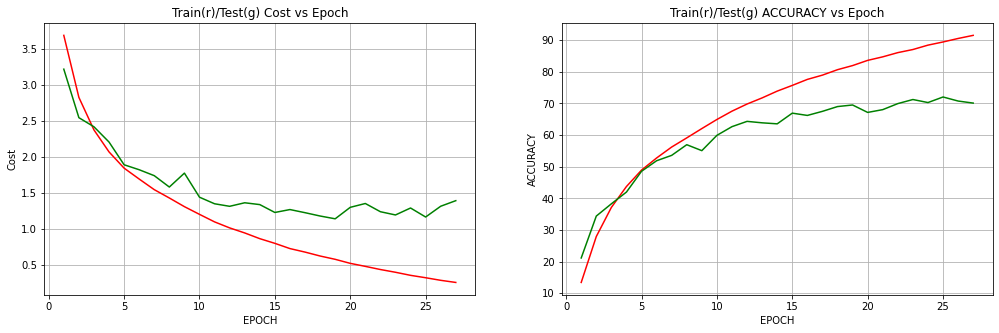

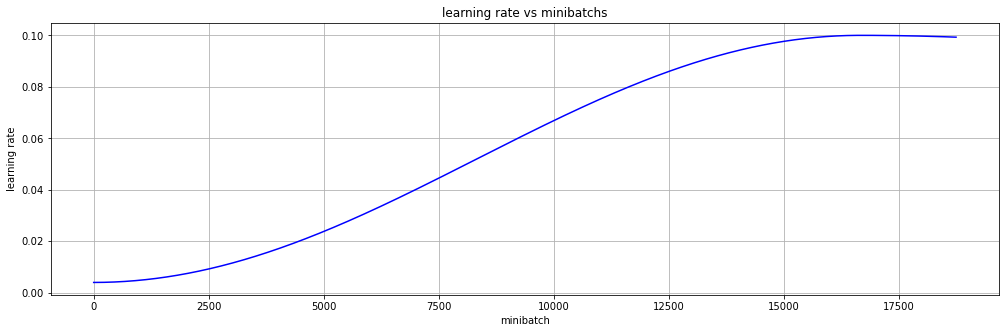

----------------train----------------
Epoch:28/80 batch_idx:230 Train Cost:0.201064
Epoch:28/80 batch_idx:461 Train Cost:0.219875
Epoch:28/80 batch_idx:692 Train Cost:0.234059
Epoch:28/80 batch_idx:693 Train Accuracy:92.162000
----------------test----------------
Epoch:28/80 Test Cost:1.271143 Test Accuracy:72.2500


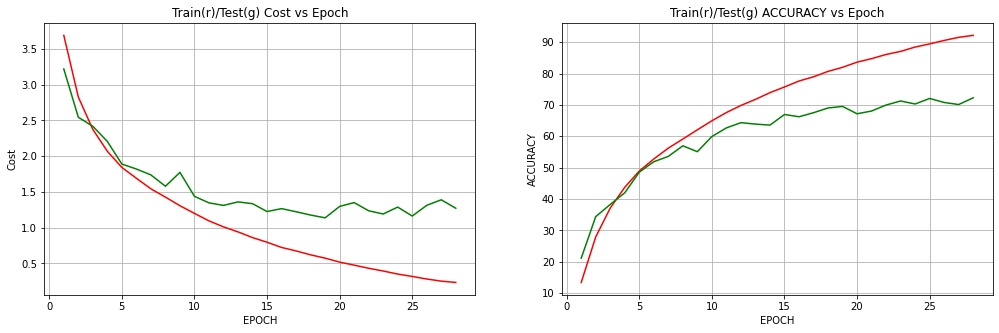

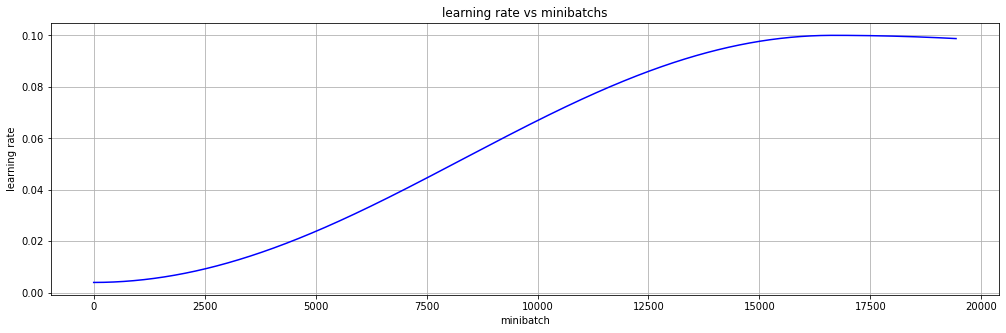

----------------train----------------
Epoch:29/80 batch_idx:230 Train Cost:0.172860
Epoch:29/80 batch_idx:461 Train Cost:0.186863
Epoch:29/80 batch_idx:692 Train Cost:0.203233
Epoch:29/80 batch_idx:693 Train Accuracy:93.208000
----------------test----------------
Epoch:29/80 Test Cost:1.433463 Test Accuracy:70.4600


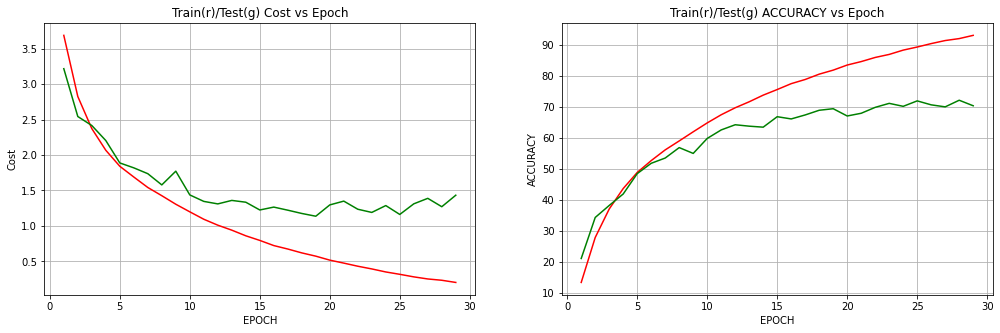

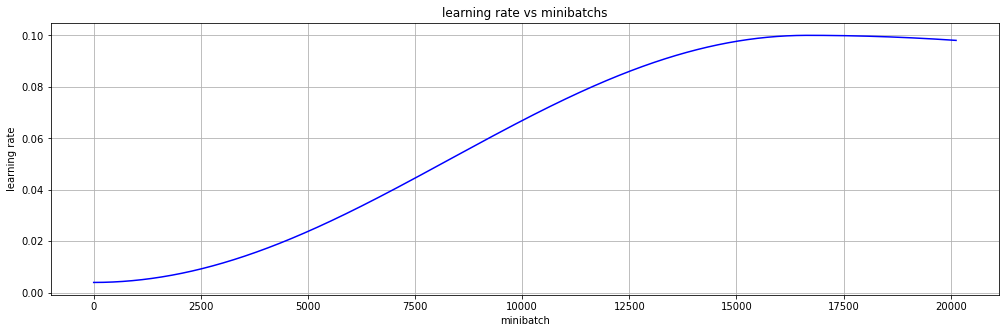

----------------train----------------
Epoch:30/80 batch_idx:230 Train Cost:0.181938
Epoch:30/80 batch_idx:461 Train Cost:0.183520
Epoch:30/80 batch_idx:692 Train Cost:0.195214
Epoch:30/80 batch_idx:693 Train Accuracy:93.404000
----------------test----------------
Epoch:30/80 Test Cost:1.320238 Test Accuracy:72.5200


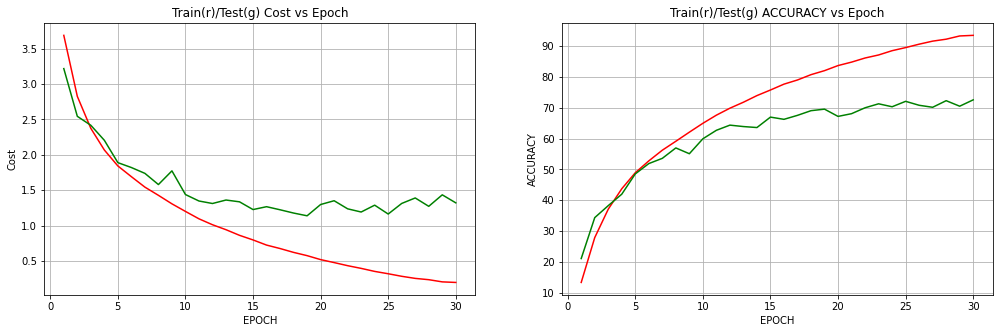

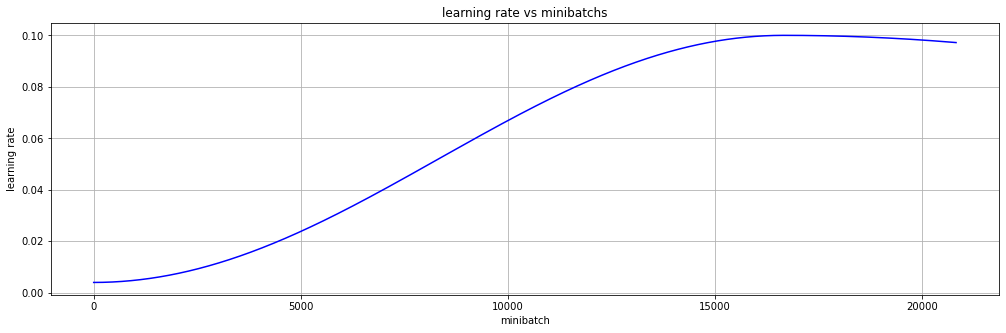

----------------train----------------
Epoch:31/80 batch_idx:230 Train Cost:0.147718
Epoch:31/80 batch_idx:461 Train Cost:0.157439
Epoch:31/80 batch_idx:692 Train Cost:0.163894
Epoch:31/80 batch_idx:693 Train Accuracy:94.618000
----------------test----------------
Epoch:31/80 Test Cost:1.269411 Test Accuracy:72.6000


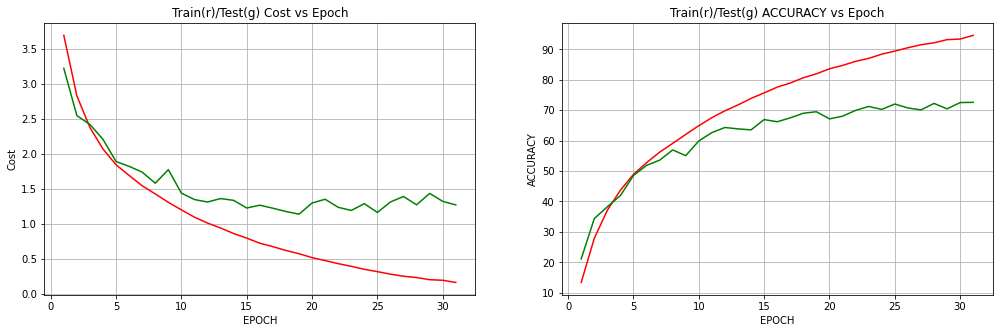

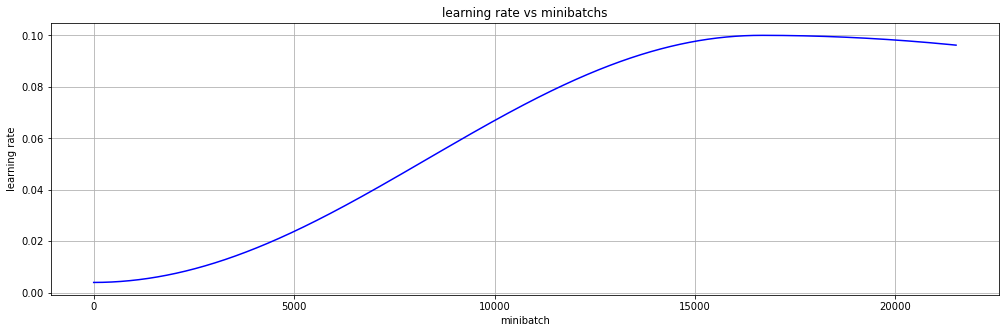

----------------train----------------
Epoch:32/80 batch_idx:230 Train Cost:0.122121
Epoch:32/80 batch_idx:461 Train Cost:0.133237
Epoch:32/80 batch_idx:692 Train Cost:0.148986
Epoch:32/80 batch_idx:693 Train Accuracy:95.016000
----------------test----------------
Epoch:32/80 Test Cost:1.385118 Test Accuracy:72.5200


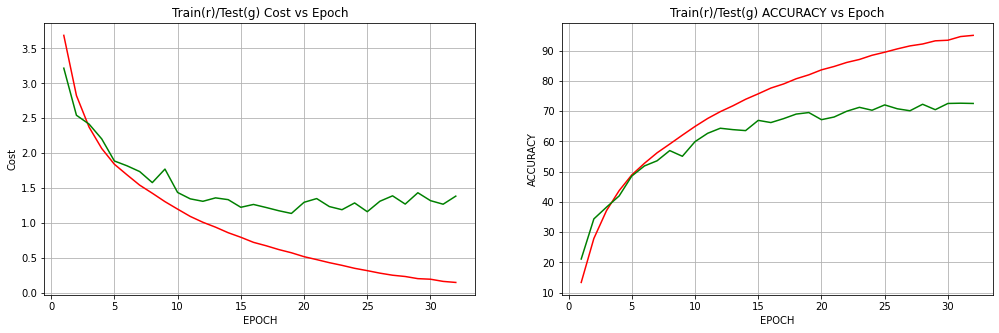

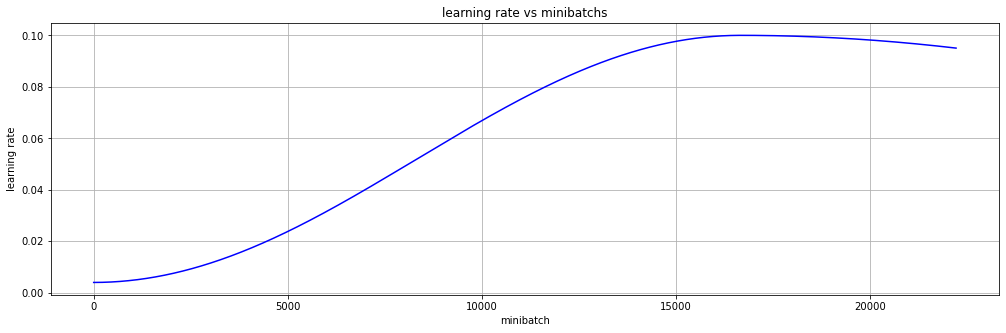

----------------train----------------
Epoch:33/80 batch_idx:230 Train Cost:0.121111
Epoch:33/80 batch_idx:461 Train Cost:0.130721
Epoch:33/80 batch_idx:692 Train Cost:0.138733
Epoch:33/80 batch_idx:693 Train Accuracy:95.288000
----------------test----------------
Epoch:33/80 Test Cost:1.368381 Test Accuracy:73.2400


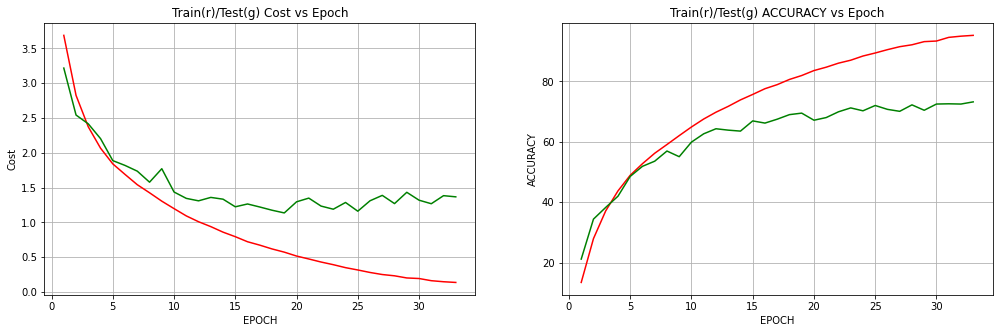

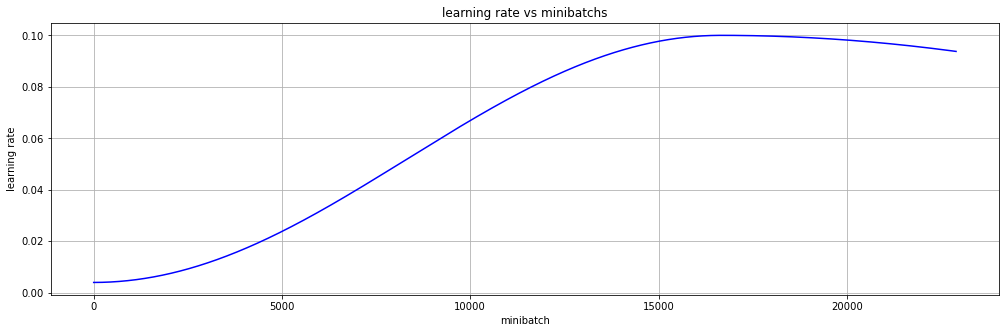

----------------train----------------
Epoch:34/80 batch_idx:230 Train Cost:0.108435
Epoch:34/80 batch_idx:461 Train Cost:0.113340
Epoch:34/80 batch_idx:692 Train Cost:0.123372
Epoch:34/80 batch_idx:693 Train Accuracy:95.832000
----------------test----------------
Epoch:34/80 Test Cost:1.425352 Test Accuracy:72.8100


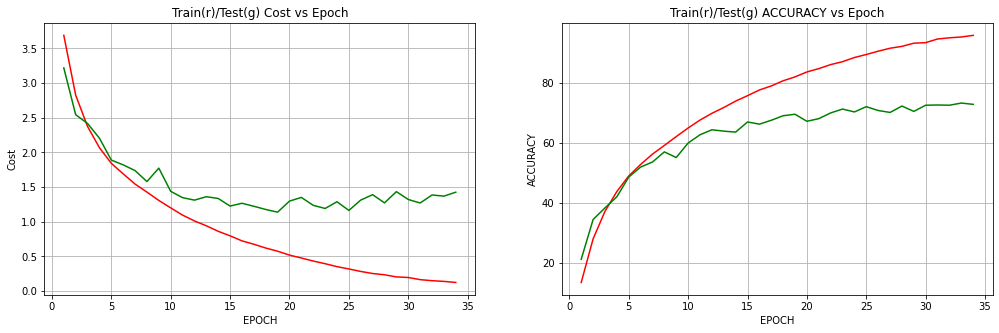

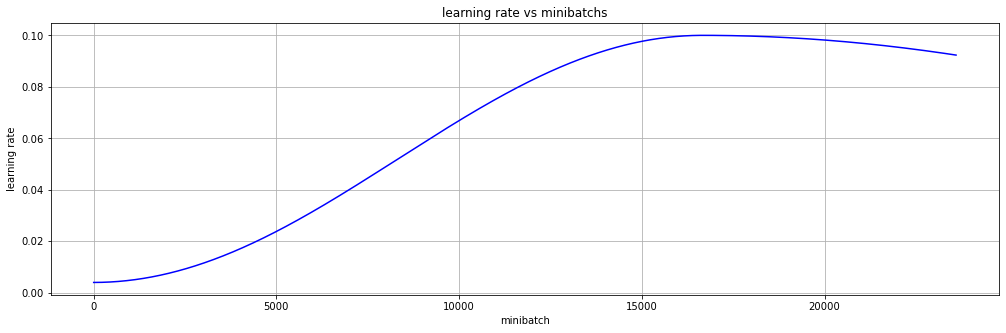

----------------train----------------
Epoch:35/80 batch_idx:230 Train Cost:0.099690
Epoch:35/80 batch_idx:461 Train Cost:0.106105
Epoch:35/80 batch_idx:692 Train Cost:0.112774
Epoch:35/80 batch_idx:693 Train Accuracy:96.226000
----------------test----------------
Epoch:35/80 Test Cost:1.406266 Test Accuracy:72.9800


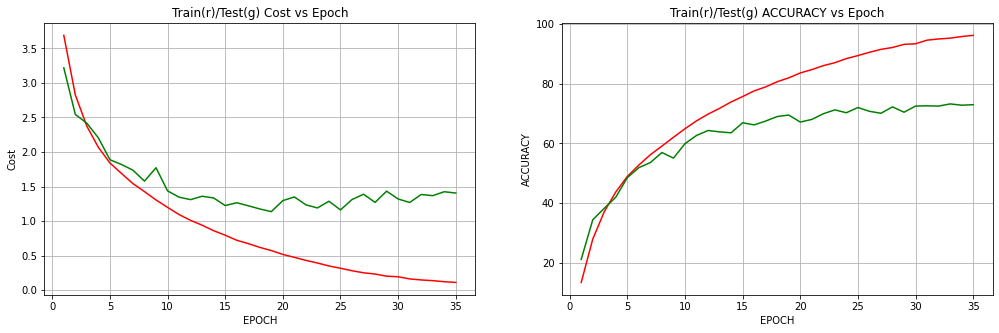

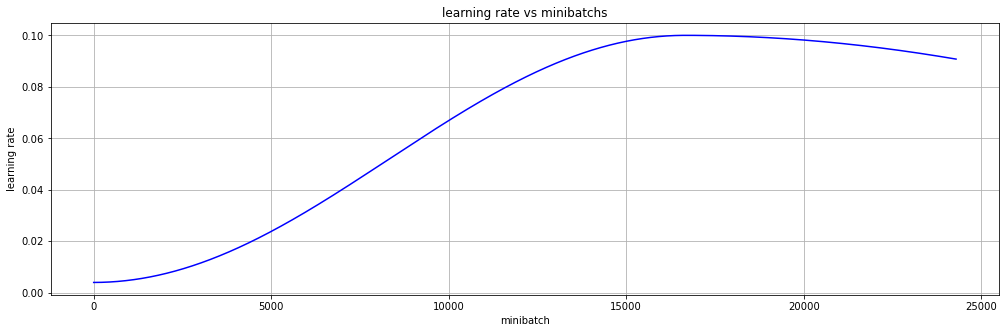

----------------train----------------
Epoch:36/80 batch_idx:230 Train Cost:0.085077
Epoch:36/80 batch_idx:461 Train Cost:0.085626
Epoch:36/80 batch_idx:692 Train Cost:0.096979
Epoch:36/80 batch_idx:693 Train Accuracy:96.750000
----------------test----------------
Epoch:36/80 Test Cost:1.459796 Test Accuracy:72.5500


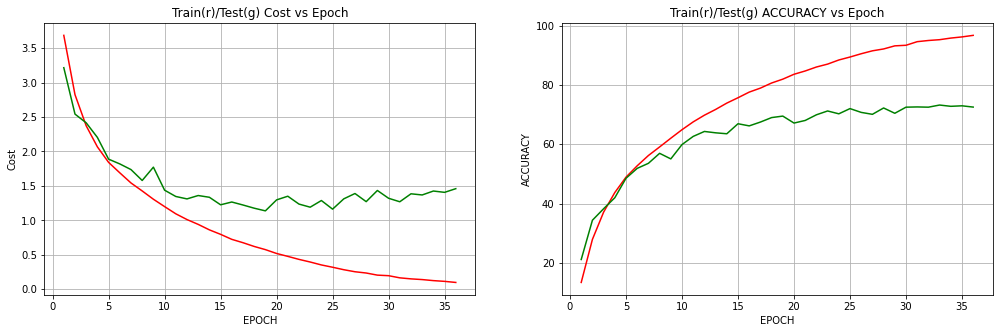

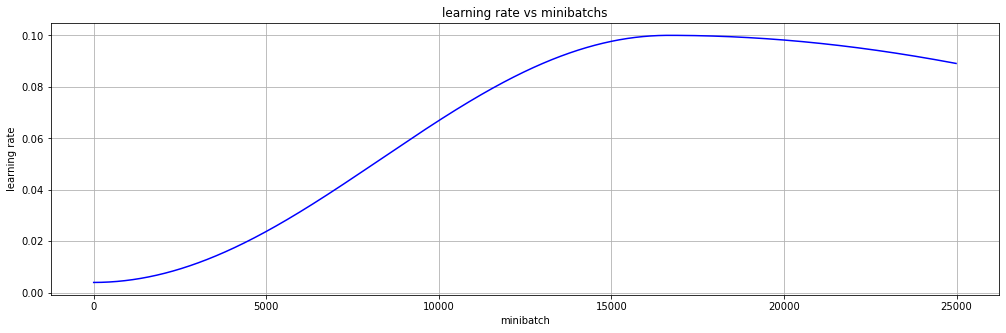

----------------train----------------
Epoch:37/80 batch_idx:230 Train Cost:0.089513
Epoch:37/80 batch_idx:461 Train Cost:0.092913
Epoch:37/80 batch_idx:692 Train Cost:0.093973
Epoch:37/80 batch_idx:693 Train Accuracy:96.816000
----------------test----------------
Epoch:37/80 Test Cost:1.550129 Test Accuracy:72.8600


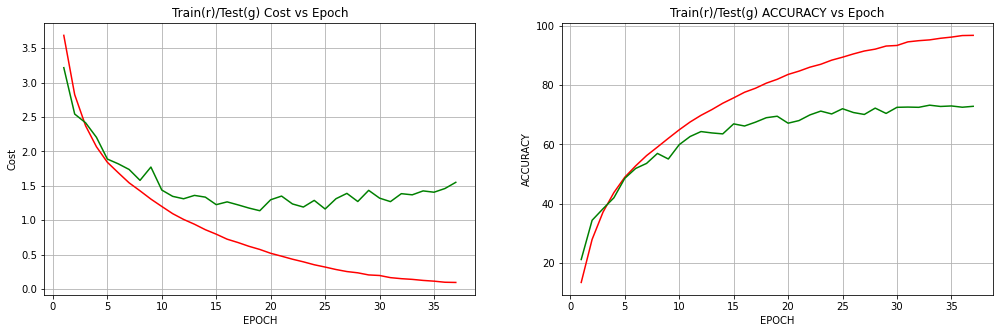

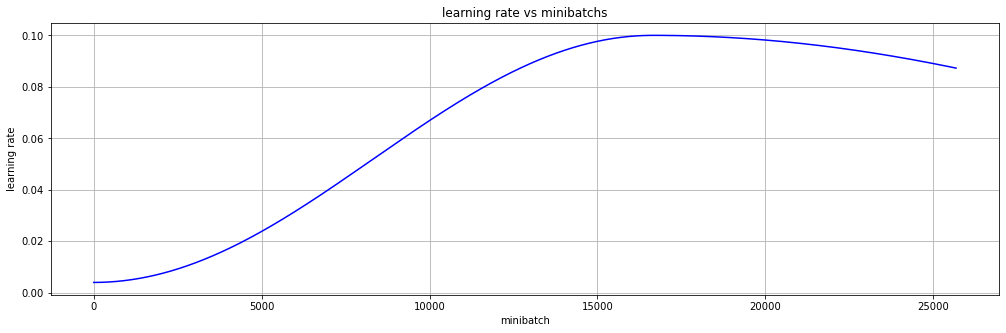

----------------train----------------
Epoch:38/80 batch_idx:230 Train Cost:0.064227
Epoch:38/80 batch_idx:461 Train Cost:0.070968
Epoch:38/80 batch_idx:692 Train Cost:0.076869
Epoch:38/80 batch_idx:693 Train Accuracy:97.436000
----------------test----------------
Epoch:38/80 Test Cost:1.458424 Test Accuracy:73.7200


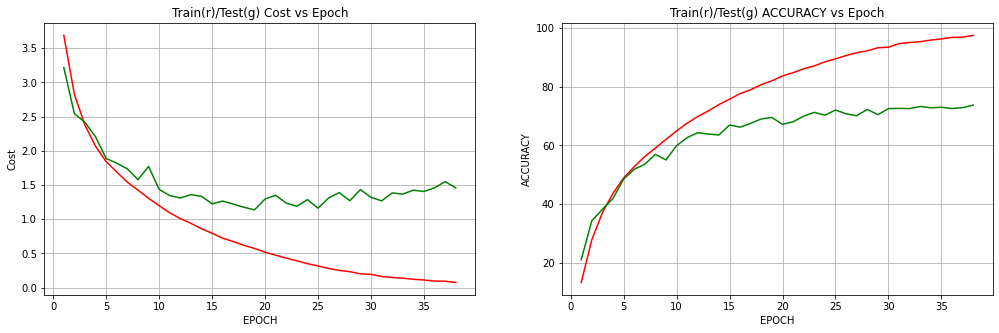

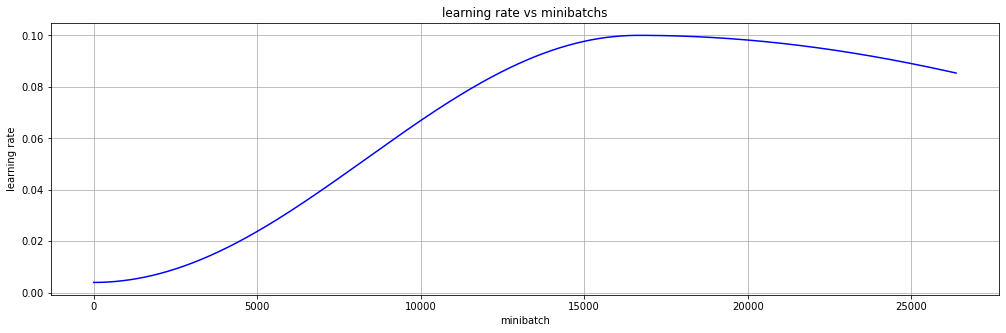

----------------train----------------
Epoch:39/80 batch_idx:230 Train Cost:0.071645
Epoch:39/80 batch_idx:461 Train Cost:0.072746
Epoch:39/80 batch_idx:692 Train Cost:0.074652
Epoch:39/80 batch_idx:693 Train Accuracy:97.476000
----------------test----------------
Epoch:39/80 Test Cost:1.485775 Test Accuracy:73.8500


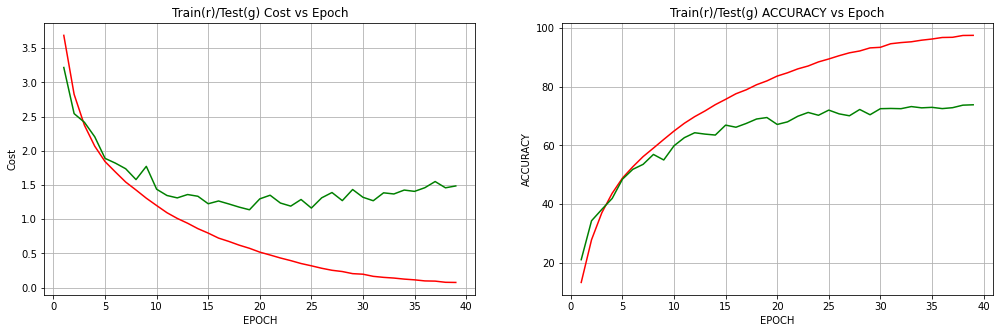

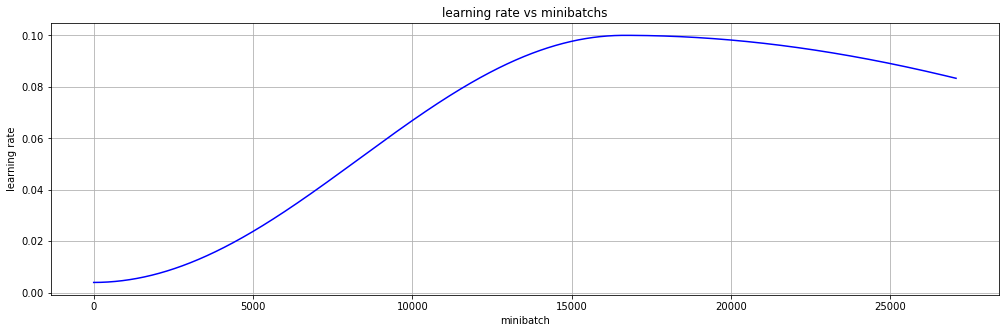

----------------train----------------
Epoch:40/80 batch_idx:230 Train Cost:0.059052
Epoch:40/80 batch_idx:461 Train Cost:0.060632
Epoch:40/80 batch_idx:692 Train Cost:0.066120
Epoch:40/80 batch_idx:693 Train Accuracy:97.800000
----------------test----------------
Epoch:40/80 Test Cost:1.476715 Test Accuracy:73.3600


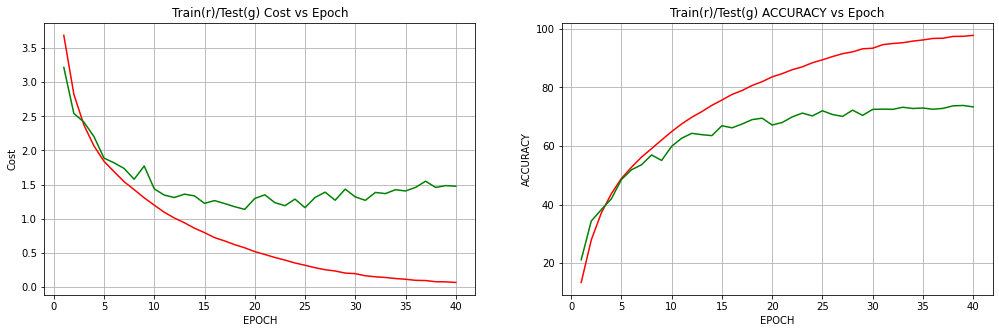

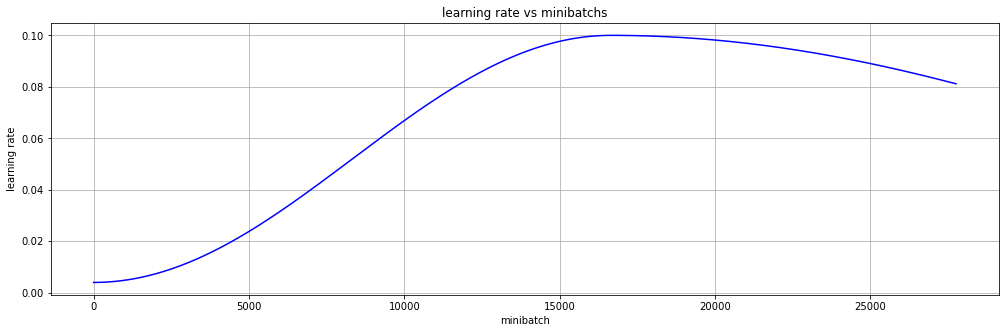

----------------train----------------
Epoch:41/80 batch_idx:230 Train Cost:0.057237
Epoch:41/80 batch_idx:461 Train Cost:0.055139
Epoch:41/80 batch_idx:692 Train Cost:0.059214
Epoch:41/80 batch_idx:693 Train Accuracy:98.074000
----------------test----------------
Epoch:41/80 Test Cost:1.476516 Test Accuracy:74.3500


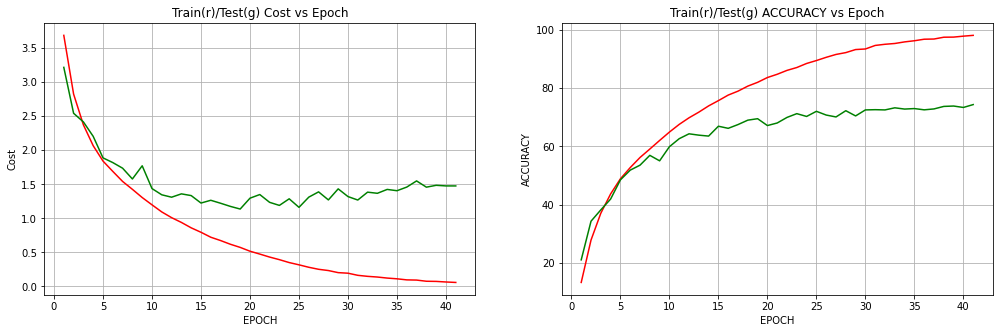

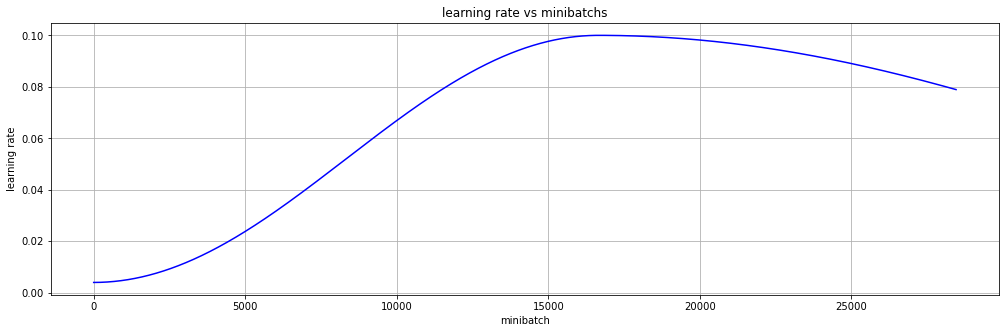

----------------train----------------
Epoch:42/80 batch_idx:230 Train Cost:0.048328
Epoch:42/80 batch_idx:461 Train Cost:0.049156
Epoch:42/80 batch_idx:692 Train Cost:0.051897
Epoch:42/80 batch_idx:693 Train Accuracy:98.276000
----------------test----------------
Epoch:42/80 Test Cost:1.453470 Test Accuracy:74.4400


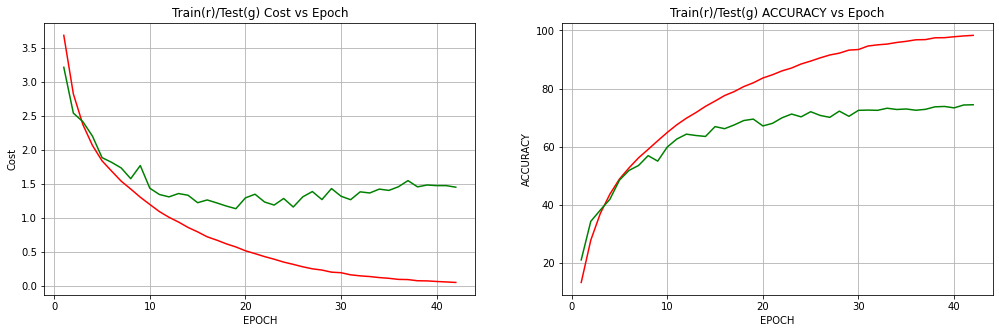

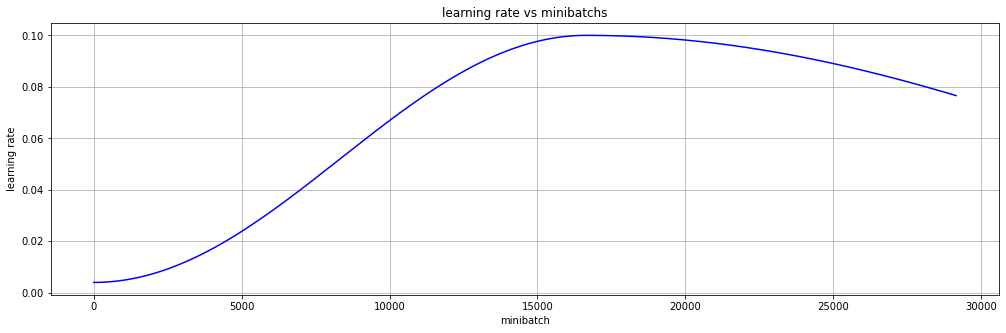

----------------train----------------
Epoch:43/80 batch_idx:230 Train Cost:0.047610
Epoch:43/80 batch_idx:461 Train Cost:0.047909
Epoch:43/80 batch_idx:692 Train Cost:0.048435
Epoch:43/80 batch_idx:693 Train Accuracy:98.452000
----------------test----------------
Epoch:43/80 Test Cost:1.472404 Test Accuracy:74.6100


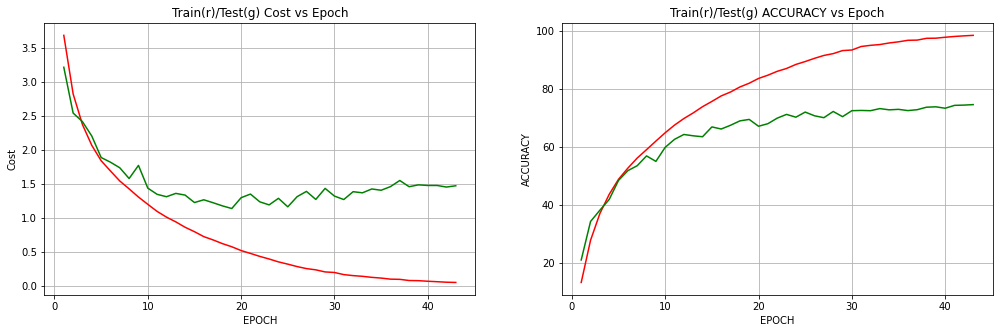

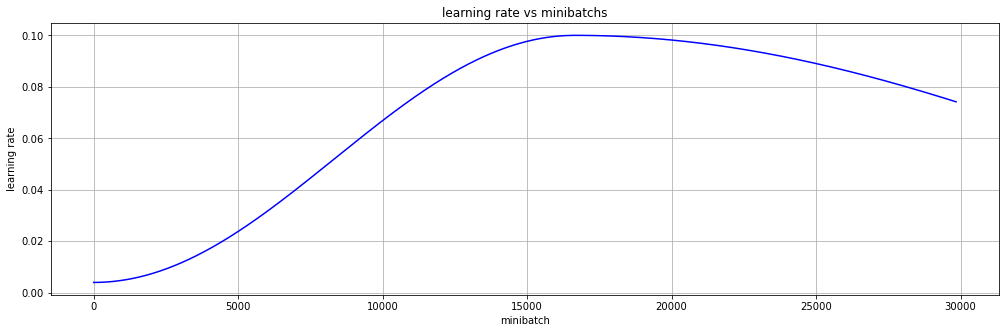

----------------train----------------
Epoch:44/80 batch_idx:230 Train Cost:0.036468
Epoch:44/80 batch_idx:461 Train Cost:0.040044
Epoch:44/80 batch_idx:692 Train Cost:0.040881
Epoch:44/80 batch_idx:693 Train Accuracy:98.662000
----------------test----------------
Epoch:44/80 Test Cost:1.476709 Test Accuracy:75.2700


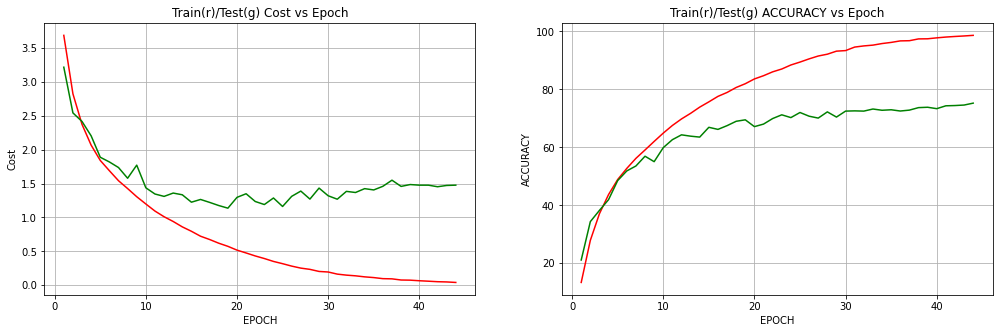

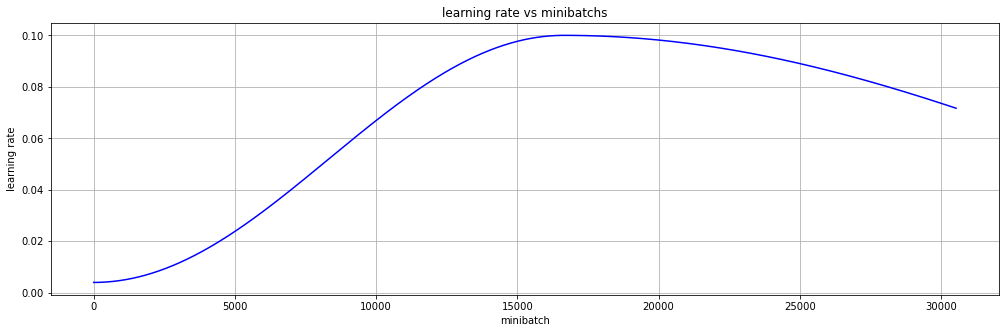

----------------train----------------
Epoch:45/80 batch_idx:230 Train Cost:0.028953
Epoch:45/80 batch_idx:461 Train Cost:0.029679
Epoch:45/80 batch_idx:692 Train Cost:0.030896
Epoch:45/80 batch_idx:693 Train Accuracy:98.994000
----------------test----------------
Epoch:45/80 Test Cost:1.468797 Test Accuracy:75.7900


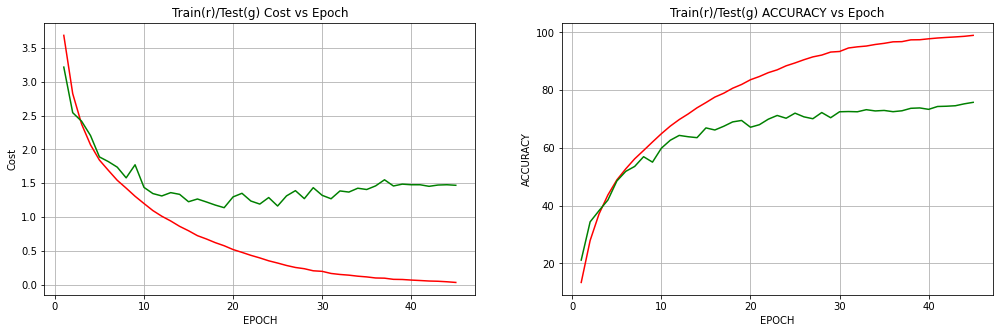

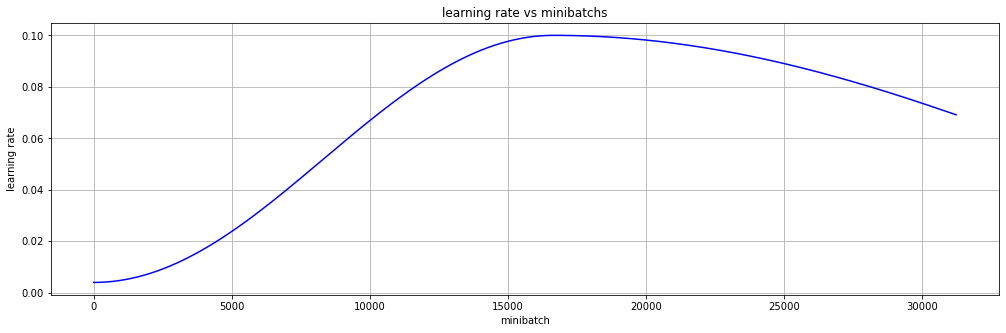

----------------train----------------
Epoch:46/80 batch_idx:230 Train Cost:0.026816
Epoch:46/80 batch_idx:461 Train Cost:0.027674
Epoch:46/80 batch_idx:692 Train Cost:0.028080
Epoch:46/80 batch_idx:693 Train Accuracy:99.094000
----------------test----------------
Epoch:46/80 Test Cost:1.531860 Test Accuracy:74.9800


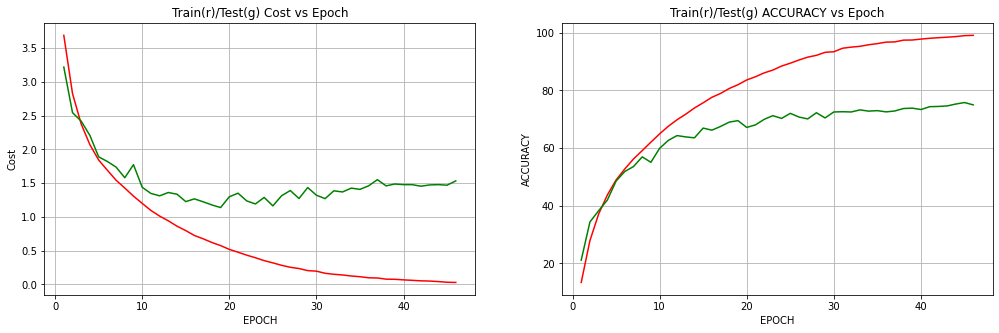

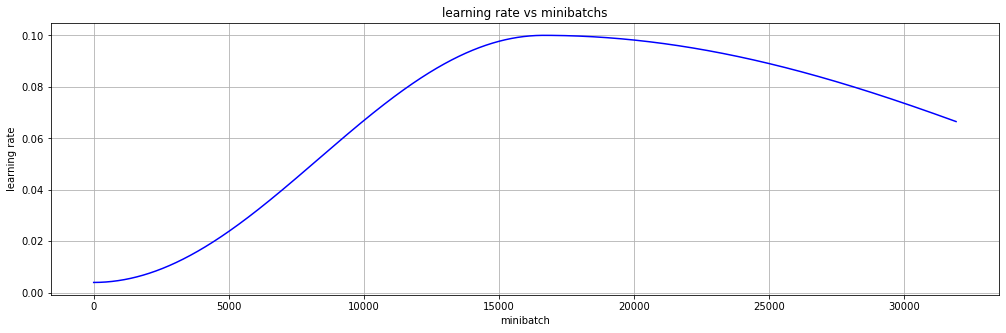

----------------train----------------
Epoch:47/80 batch_idx:230 Train Cost:0.022126
Epoch:47/80 batch_idx:461 Train Cost:0.024230
Epoch:47/80 batch_idx:692 Train Cost:0.024426
Epoch:47/80 batch_idx:693 Train Accuracy:99.248000
----------------test----------------
Epoch:47/80 Test Cost:1.495939 Test Accuracy:75.7100


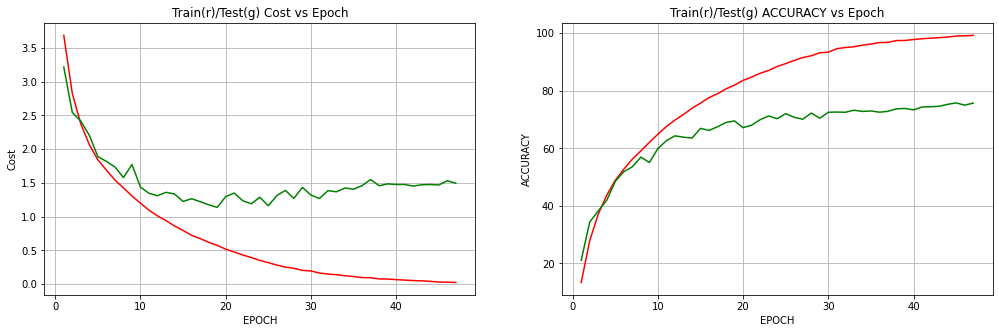

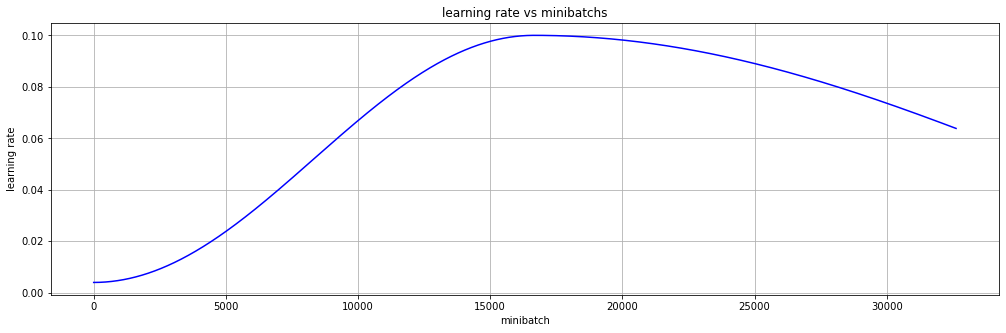

----------------train----------------
Epoch:48/80 batch_idx:230 Train Cost:0.019343
Epoch:48/80 batch_idx:461 Train Cost:0.019610
Epoch:48/80 batch_idx:692 Train Cost:0.021334
Epoch:48/80 batch_idx:693 Train Accuracy:99.324000
----------------test----------------
Epoch:48/80 Test Cost:1.510767 Test Accuracy:75.3400


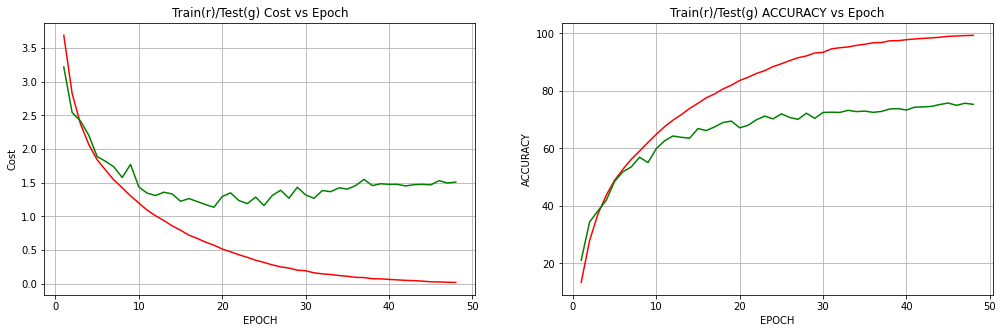

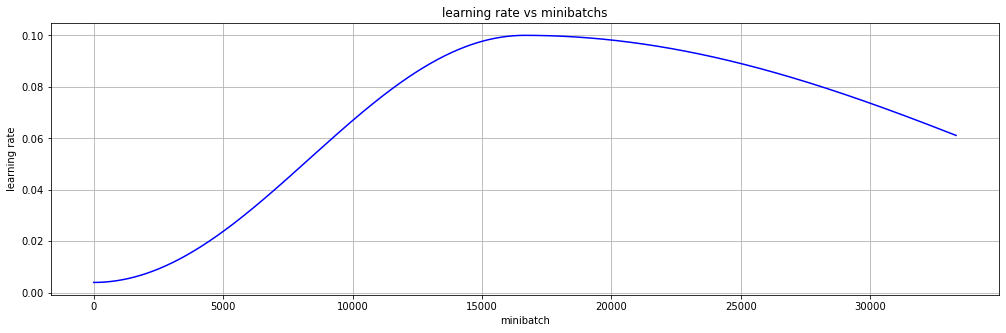

----------------train----------------
Epoch:49/80 batch_idx:230 Train Cost:0.022426
Epoch:49/80 batch_idx:461 Train Cost:0.021721
Epoch:49/80 batch_idx:692 Train Cost:0.021310
Epoch:49/80 batch_idx:693 Train Accuracy:99.334000
----------------test----------------
Epoch:49/80 Test Cost:1.500834 Test Accuracy:75.9600


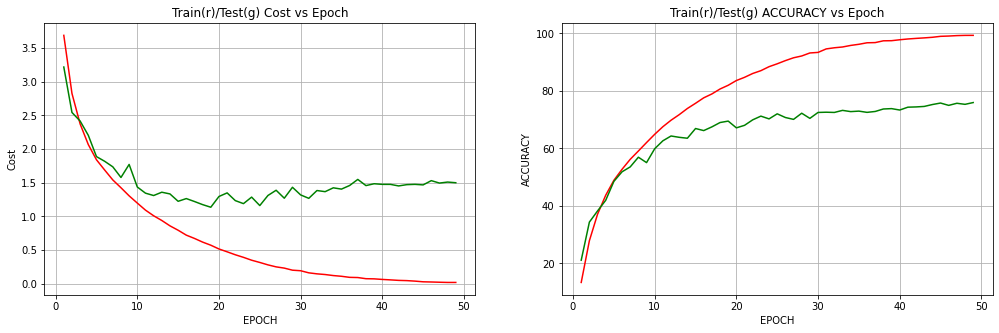

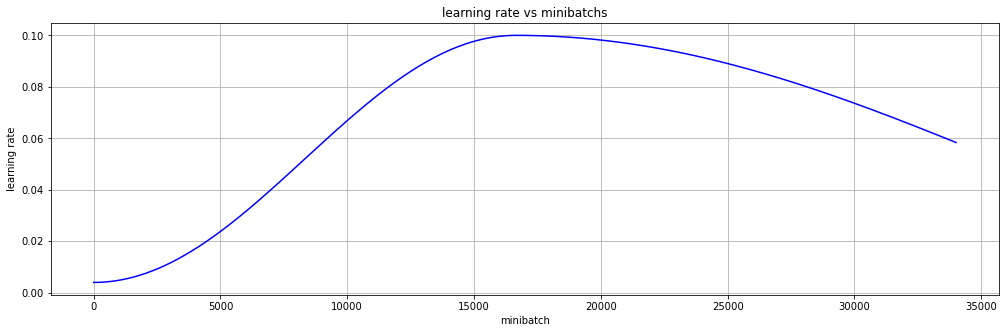

----------------train----------------
Epoch:50/80 batch_idx:230 Train Cost:0.017136
Epoch:50/80 batch_idx:461 Train Cost:0.019308
Epoch:50/80 batch_idx:692 Train Cost:0.020178
Epoch:50/80 batch_idx:693 Train Accuracy:99.346000
----------------test----------------
Epoch:50/80 Test Cost:1.537006 Test Accuracy:75.2800


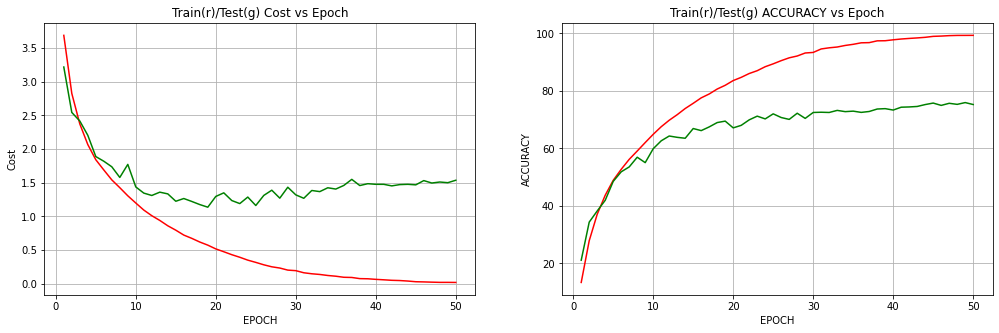

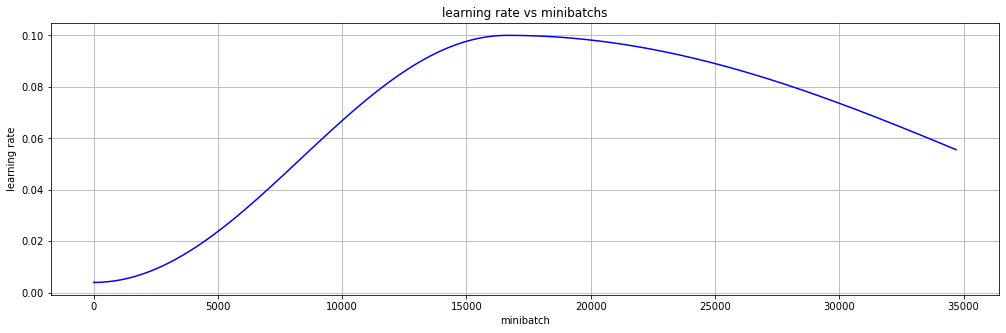

----------------train----------------
Epoch:51/80 batch_idx:230 Train Cost:0.017567
Epoch:51/80 batch_idx:461 Train Cost:0.014848
Epoch:51/80 batch_idx:692 Train Cost:0.015507
Epoch:51/80 batch_idx:693 Train Accuracy:99.500000
----------------test----------------
Epoch:51/80 Test Cost:1.526923 Test Accuracy:75.6300


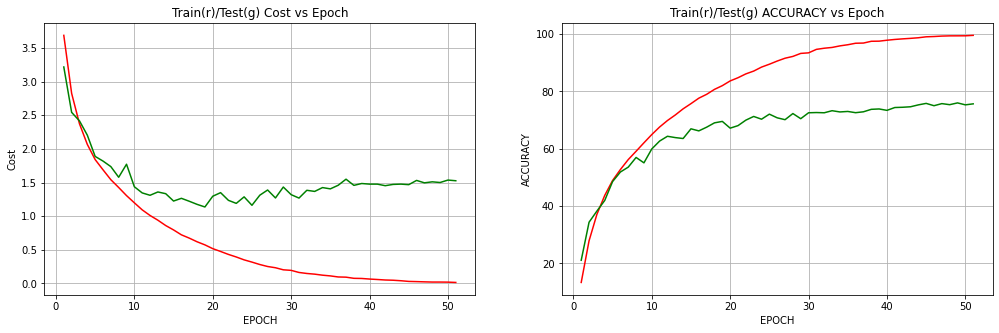

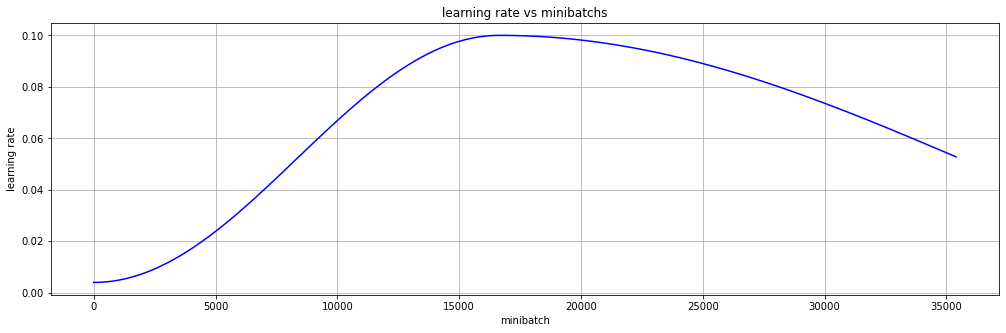

----------------train----------------
Epoch:52/80 batch_idx:230 Train Cost:0.012771
Epoch:52/80 batch_idx:461 Train Cost:0.011618
Epoch:52/80 batch_idx:692 Train Cost:0.012201
Epoch:52/80 batch_idx:693 Train Accuracy:99.626000
----------------test----------------
Epoch:52/80 Test Cost:1.499426 Test Accuracy:75.9300


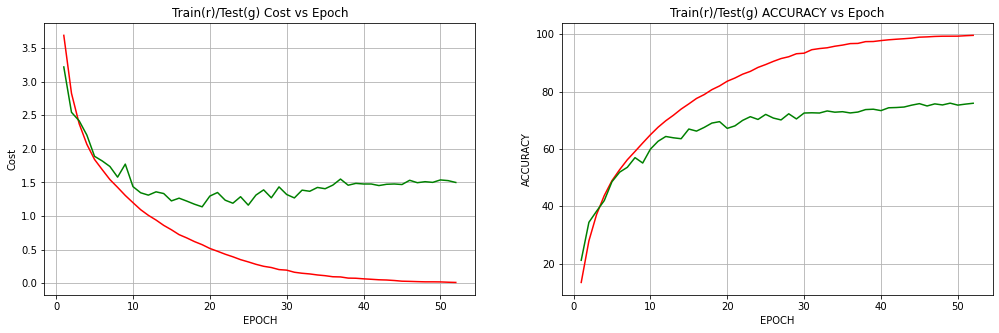

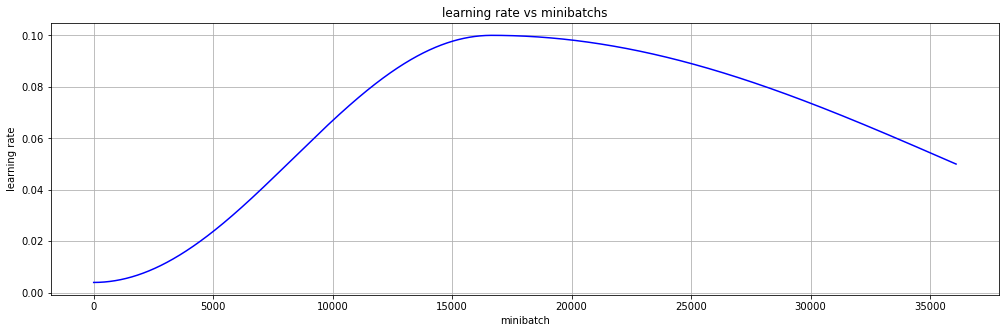

----------------train----------------
Epoch:53/80 batch_idx:230 Train Cost:0.010824
Epoch:53/80 batch_idx:461 Train Cost:0.011327
Epoch:53/80 batch_idx:692 Train Cost:0.010977
Epoch:53/80 batch_idx:693 Train Accuracy:99.670000
----------------test----------------
Epoch:53/80 Test Cost:1.485140 Test Accuracy:76.2400


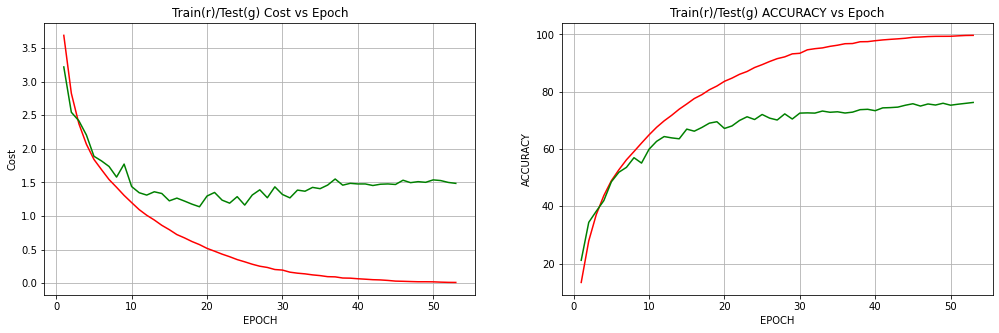

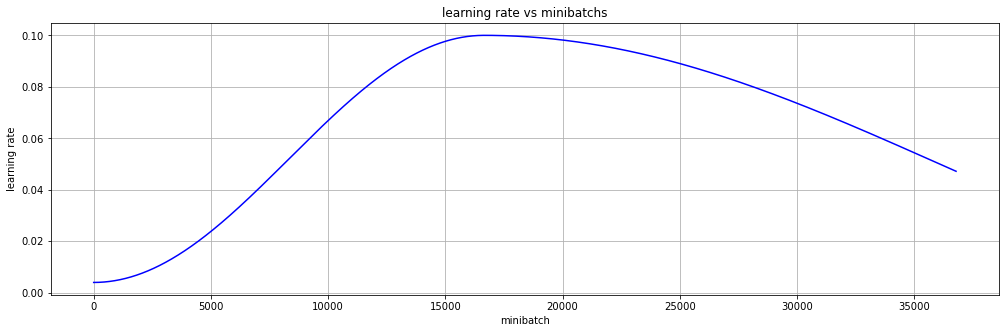

----------------train----------------
Epoch:54/80 batch_idx:230 Train Cost:0.010324
Epoch:54/80 batch_idx:461 Train Cost:0.010196
Epoch:54/80 batch_idx:692 Train Cost:0.010595
Epoch:54/80 batch_idx:693 Train Accuracy:99.684000
----------------test----------------
Epoch:54/80 Test Cost:1.513933 Test Accuracy:76.4100


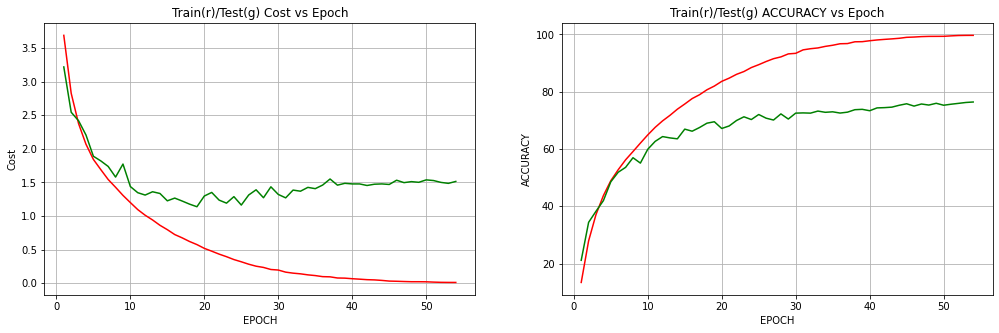

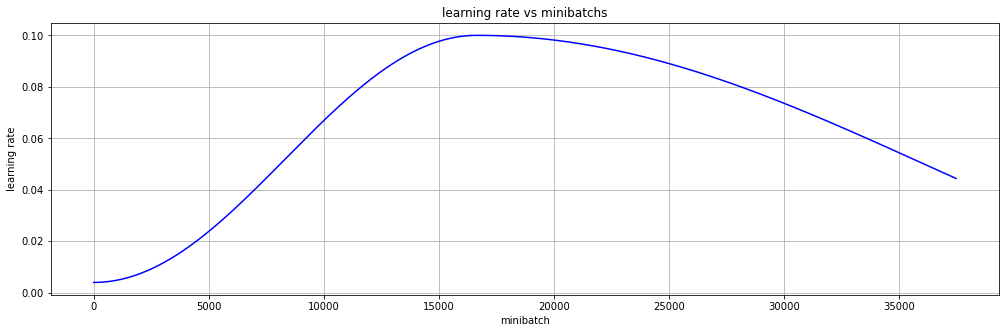

----------------train----------------
Epoch:55/80 batch_idx:230 Train Cost:0.007370
Epoch:55/80 batch_idx:461 Train Cost:0.007539
Epoch:55/80 batch_idx:692 Train Cost:0.007809
Epoch:55/80 batch_idx:693 Train Accuracy:99.740000
----------------test----------------
Epoch:55/80 Test Cost:1.498560 Test Accuracy:76.9300


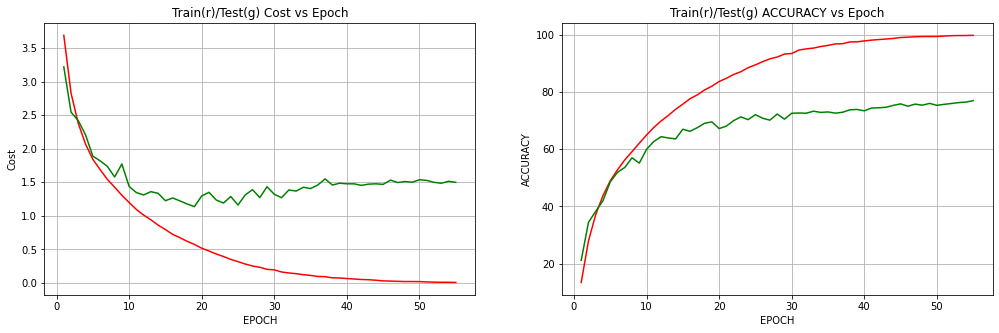

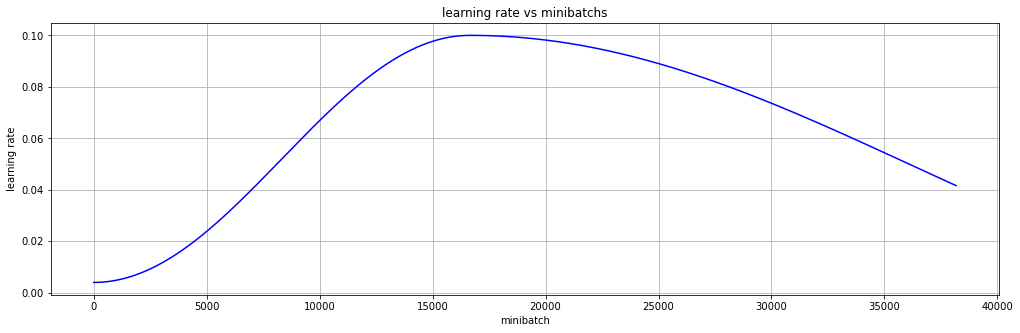

----------------train----------------
Epoch:56/80 batch_idx:230 Train Cost:0.008765
Epoch:56/80 batch_idx:461 Train Cost:0.008901
Epoch:56/80 batch_idx:692 Train Cost:0.008105
Epoch:56/80 batch_idx:693 Train Accuracy:99.736000
----------------test----------------
Epoch:56/80 Test Cost:1.485265 Test Accuracy:76.7400


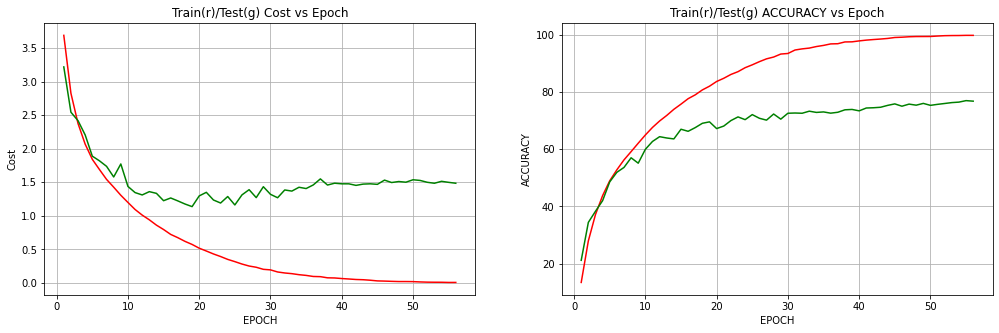

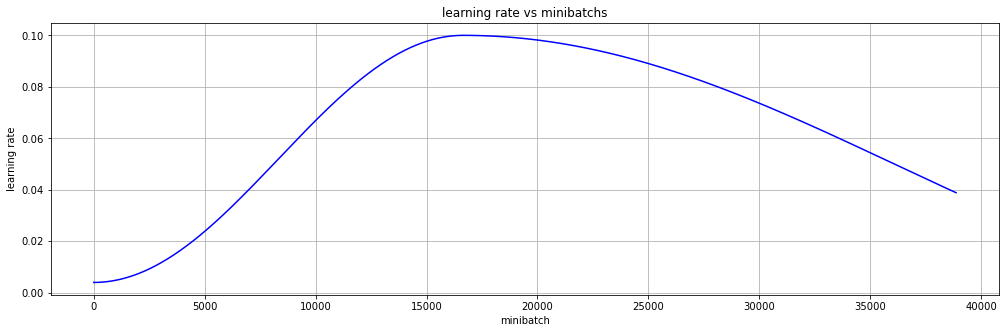

----------------train----------------
Epoch:57/80 batch_idx:230 Train Cost:0.006816
Epoch:57/80 batch_idx:461 Train Cost:0.006014
Epoch:57/80 batch_idx:692 Train Cost:0.005922
Epoch:57/80 batch_idx:693 Train Accuracy:99.814000
----------------test----------------
Epoch:57/80 Test Cost:1.495260 Test Accuracy:76.6000


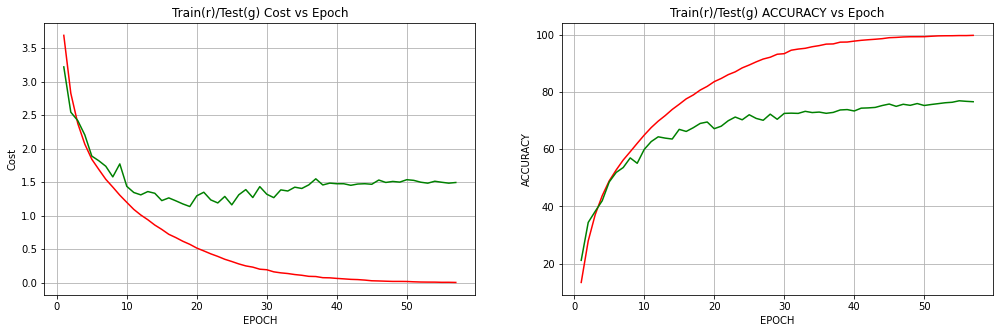

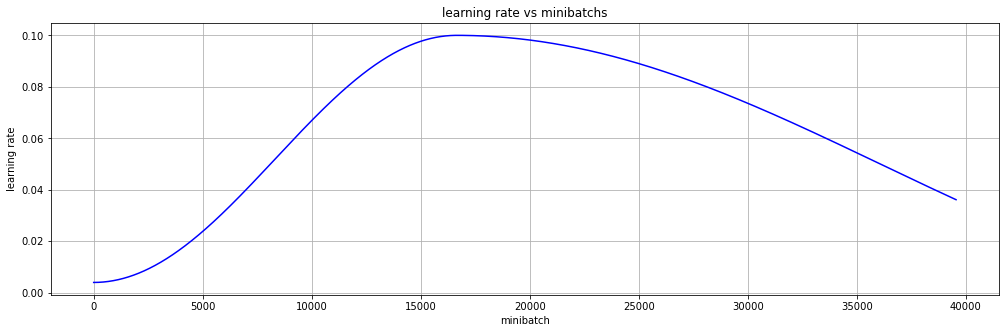

----------------train----------------
Epoch:58/80 batch_idx:230 Train Cost:0.003843
Epoch:58/80 batch_idx:461 Train Cost:0.003967
Epoch:58/80 batch_idx:692 Train Cost:0.003857
Epoch:58/80 batch_idx:693 Train Accuracy:99.882000
----------------test----------------
Epoch:58/80 Test Cost:1.490601 Test Accuracy:76.8100


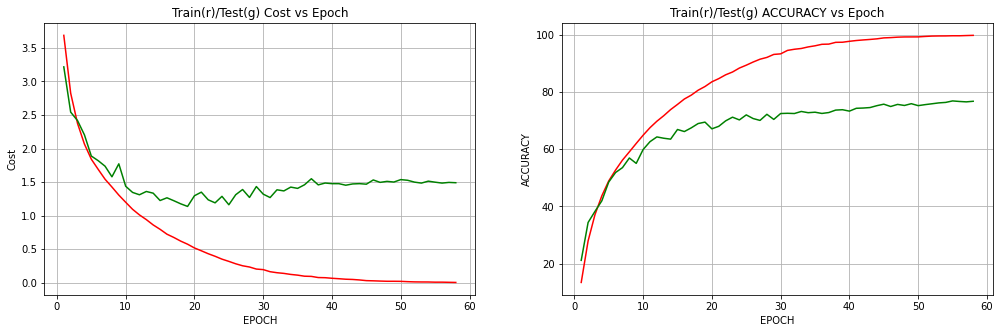

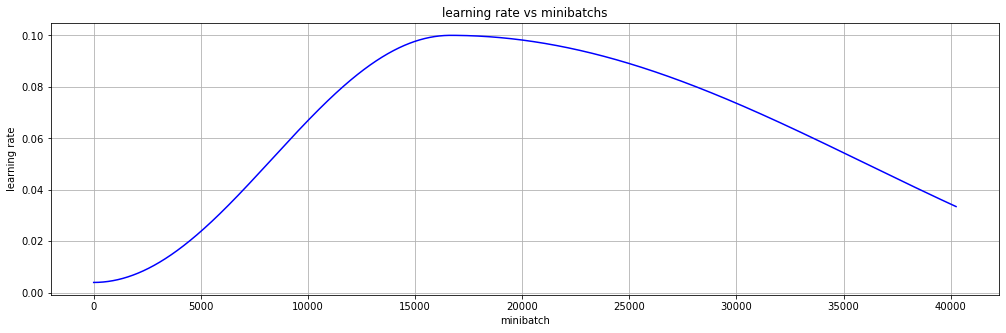

----------------train----------------
Epoch:59/80 batch_idx:230 Train Cost:0.002877
Epoch:59/80 batch_idx:461 Train Cost:0.004265
Epoch:59/80 batch_idx:692 Train Cost:0.004225
Epoch:59/80 batch_idx:693 Train Accuracy:99.854000
----------------test----------------
Epoch:59/80 Test Cost:1.504186 Test Accuracy:76.8000


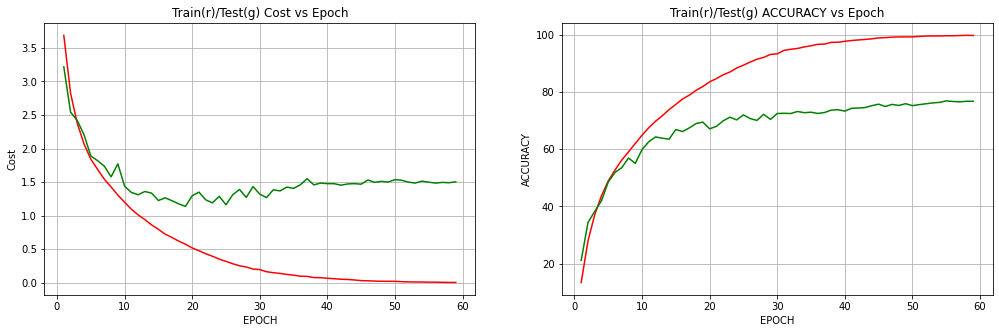

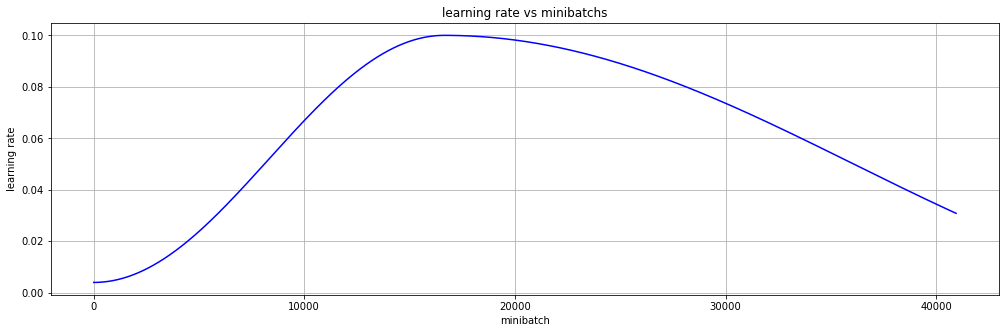

----------------train----------------
Epoch:60/80 batch_idx:230 Train Cost:0.003172
Epoch:60/80 batch_idx:461 Train Cost:0.003493
Epoch:60/80 batch_idx:692 Train Cost:0.003665
Epoch:60/80 batch_idx:693 Train Accuracy:99.864000
----------------test----------------
Epoch:60/80 Test Cost:1.488318 Test Accuracy:77.0400


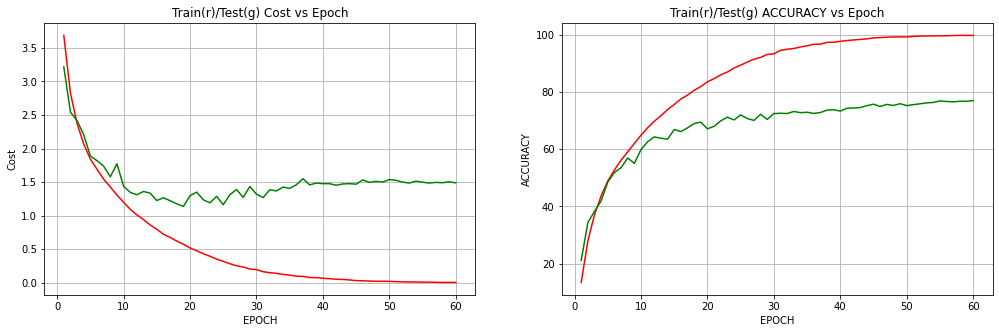

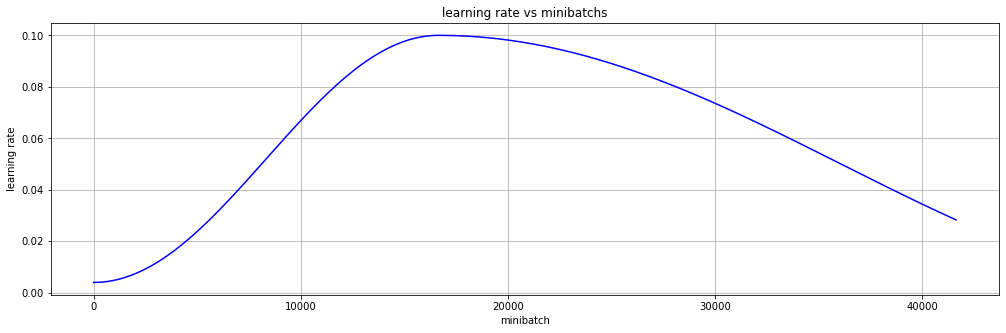

----------------train----------------
Epoch:61/80 batch_idx:230 Train Cost:0.003016
Epoch:61/80 batch_idx:461 Train Cost:0.002873
Epoch:61/80 batch_idx:692 Train Cost:0.003215
Epoch:61/80 batch_idx:693 Train Accuracy:99.868000
----------------test----------------
Epoch:61/80 Test Cost:1.487385 Test Accuracy:77.2900


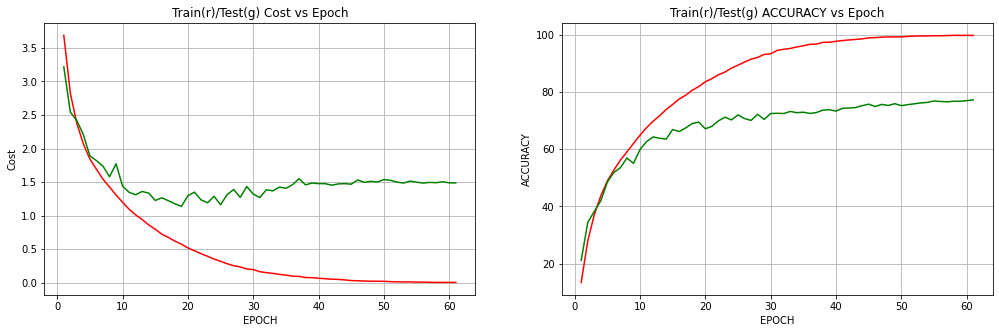

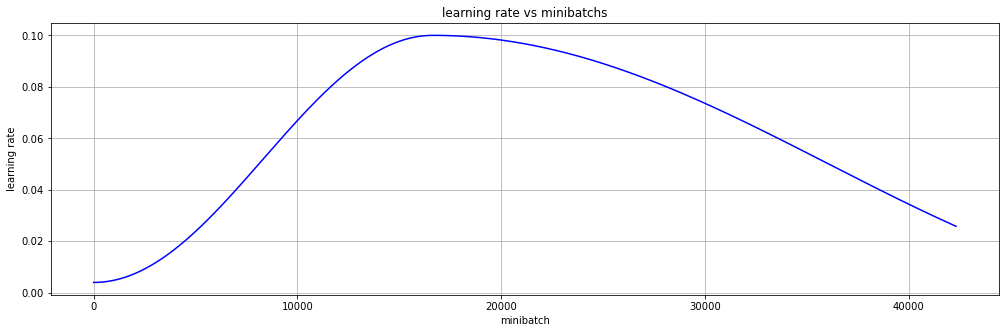

----------------train----------------
Epoch:62/80 batch_idx:230 Train Cost:0.002553
Epoch:62/80 batch_idx:461 Train Cost:0.002753
Epoch:62/80 batch_idx:692 Train Cost:0.002602
Epoch:62/80 batch_idx:693 Train Accuracy:99.888000
----------------test----------------
Epoch:62/80 Test Cost:1.478555 Test Accuracy:76.9300


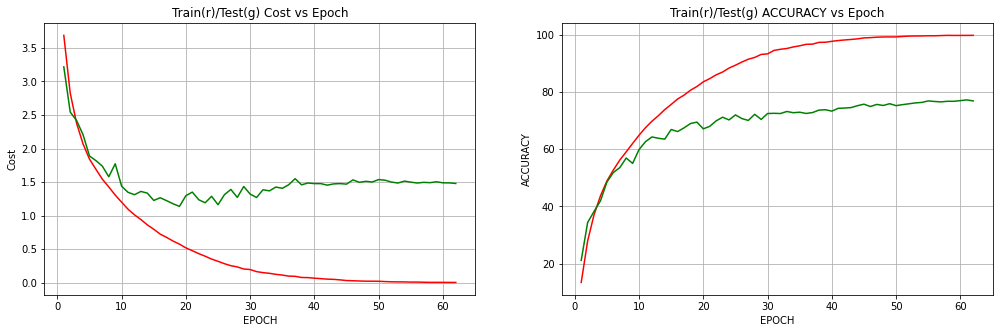

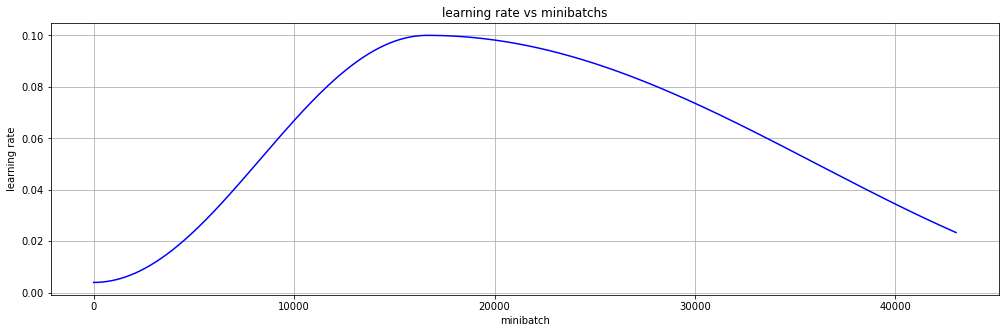

----------------train----------------
Epoch:63/80 batch_idx:230 Train Cost:0.002878
Epoch:63/80 batch_idx:461 Train Cost:0.002811
Epoch:63/80 batch_idx:692 Train Cost:0.002856
Epoch:63/80 batch_idx:693 Train Accuracy:99.884000
----------------test----------------
Epoch:63/80 Test Cost:1.476988 Test Accuracy:77.0200


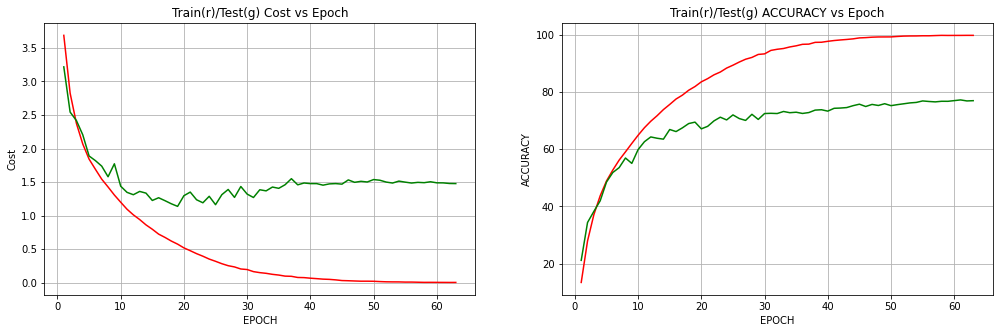

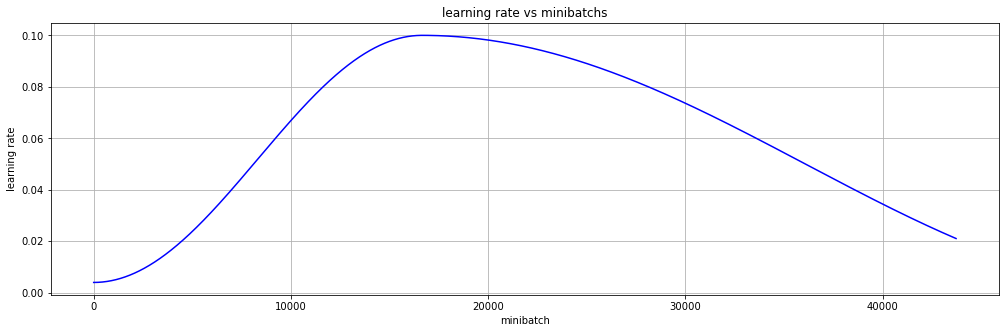

----------------train----------------
Epoch:64/80 batch_idx:230 Train Cost:0.003022
Epoch:64/80 batch_idx:461 Train Cost:0.002550
Epoch:64/80 batch_idx:692 Train Cost:0.002313
Epoch:64/80 batch_idx:693 Train Accuracy:99.888000
----------------test----------------
Epoch:64/80 Test Cost:1.479804 Test Accuracy:77.1100


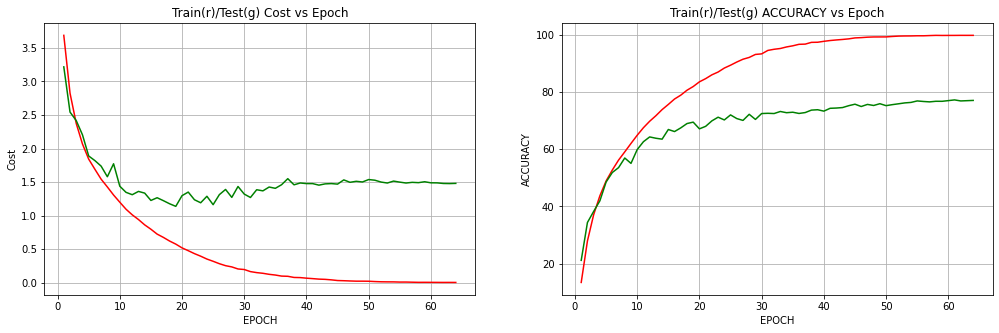

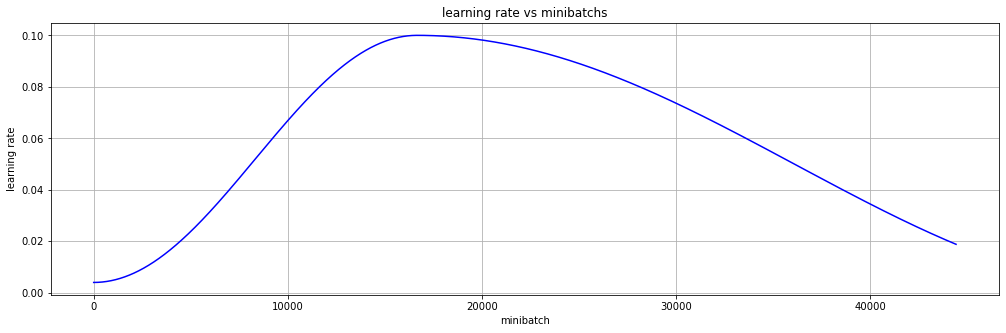

----------------train----------------
Epoch:65/80 batch_idx:230 Train Cost:0.002108
Epoch:65/80 batch_idx:461 Train Cost:0.002151
Epoch:65/80 batch_idx:692 Train Cost:0.002290
Epoch:65/80 batch_idx:693 Train Accuracy:99.890000
----------------test----------------
Epoch:65/80 Test Cost:1.484395 Test Accuracy:77.2100


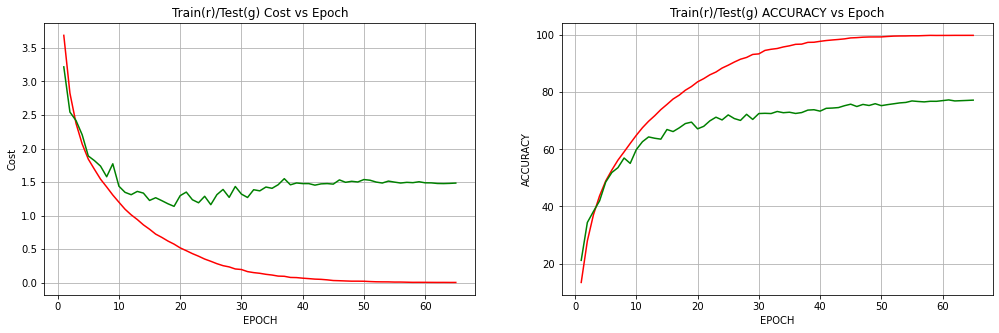

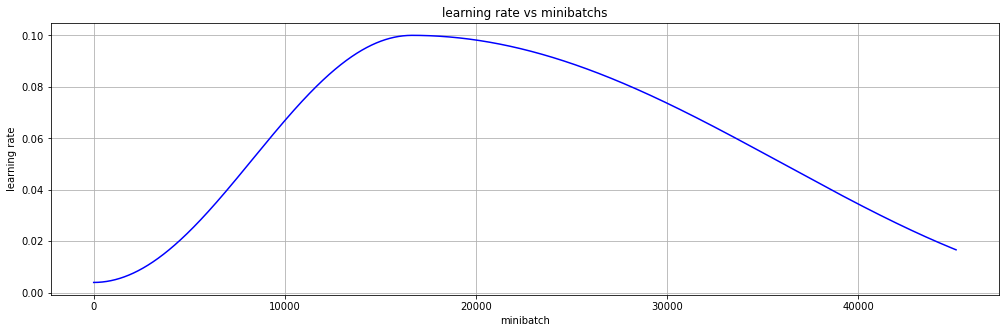

----------------train----------------
Epoch:66/80 batch_idx:230 Train Cost:0.001650
Epoch:66/80 batch_idx:461 Train Cost:0.001810
Epoch:66/80 batch_idx:692 Train Cost:0.001784
Epoch:66/80 batch_idx:693 Train Accuracy:99.900000
----------------test----------------
Epoch:66/80 Test Cost:1.487894 Test Accuracy:77.1300


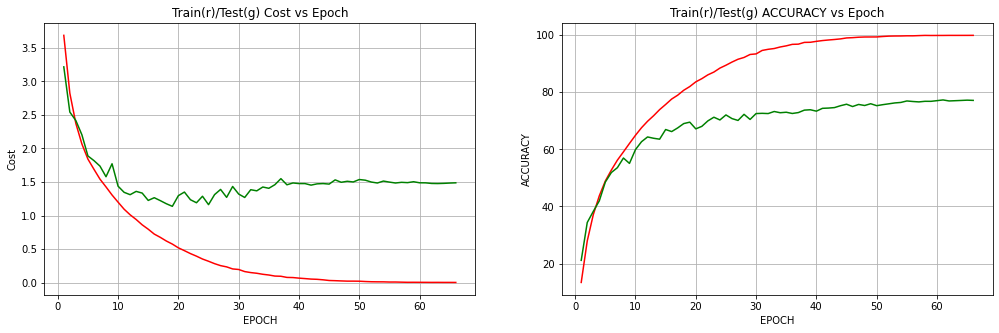

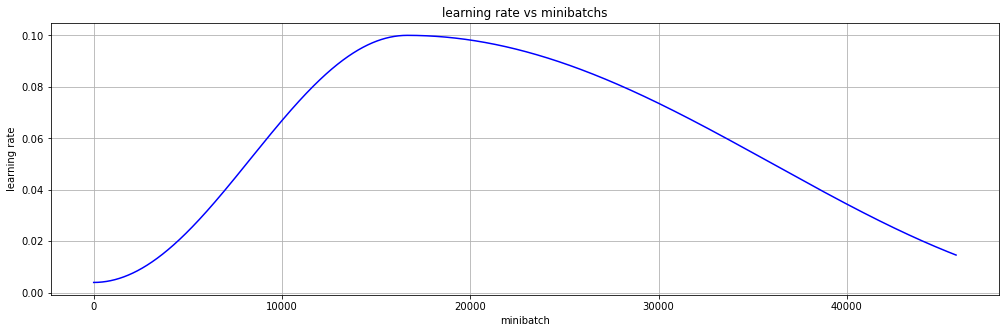

----------------train----------------
Epoch:67/80 batch_idx:230 Train Cost:0.001745
Epoch:67/80 batch_idx:461 Train Cost:0.001777
Epoch:67/80 batch_idx:692 Train Cost:0.001914
Epoch:67/80 batch_idx:693 Train Accuracy:99.896000
----------------test----------------
Epoch:67/80 Test Cost:1.475234 Test Accuracy:77.3000


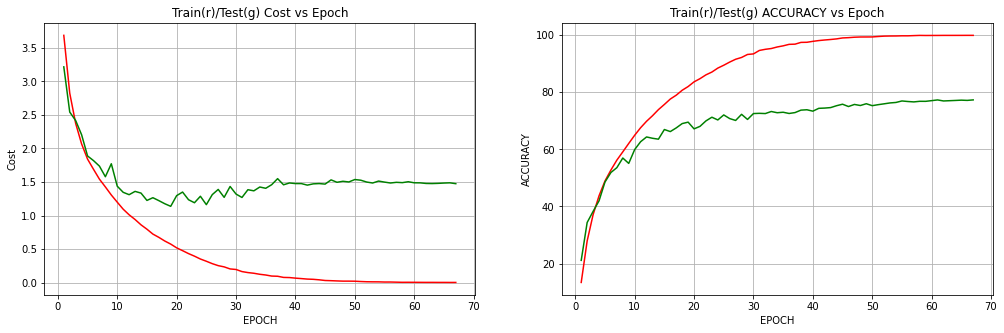

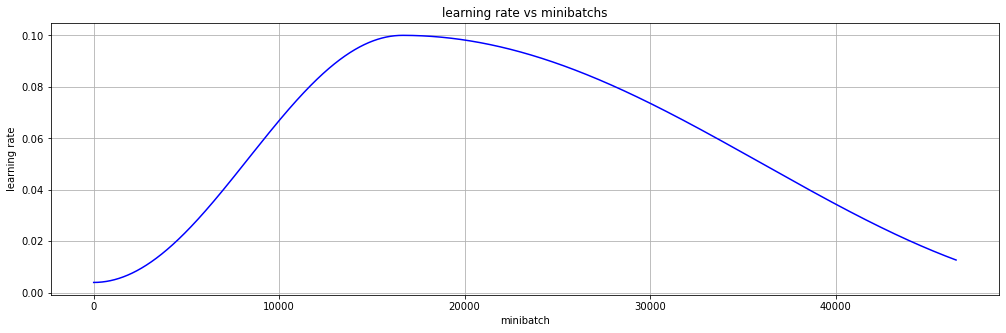

----------------train----------------
Epoch:68/80 batch_idx:230 Train Cost:0.001860
Epoch:68/80 batch_idx:461 Train Cost:0.001773
Epoch:68/80 batch_idx:692 Train Cost:0.001795
Epoch:68/80 batch_idx:693 Train Accuracy:99.900000
----------------test----------------
Epoch:68/80 Test Cost:1.470043 Test Accuracy:77.4300


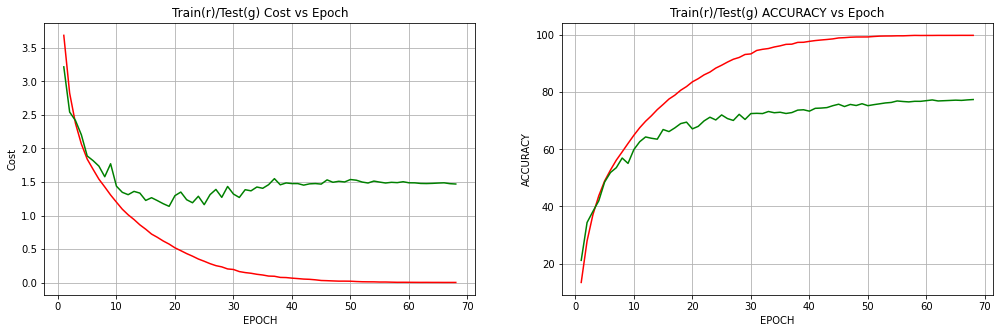

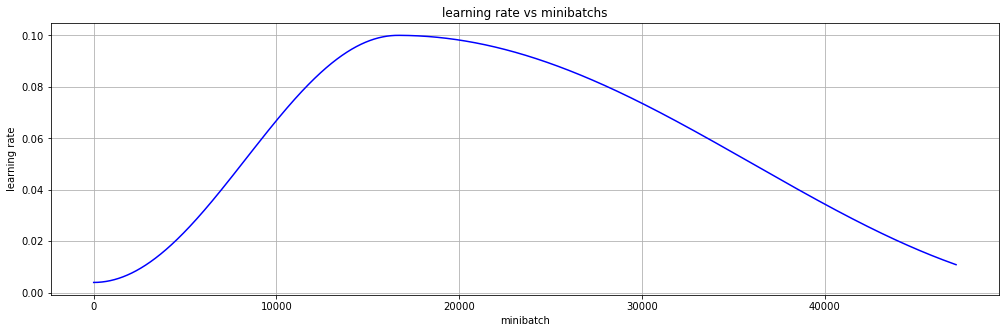

----------------train----------------
Epoch:69/80 batch_idx:230 Train Cost:0.001902
Epoch:69/80 batch_idx:461 Train Cost:0.001748
Epoch:69/80 batch_idx:692 Train Cost:0.001760
Epoch:69/80 batch_idx:693 Train Accuracy:99.898000
----------------test----------------
Epoch:69/80 Test Cost:1.476991 Test Accuracy:77.3100


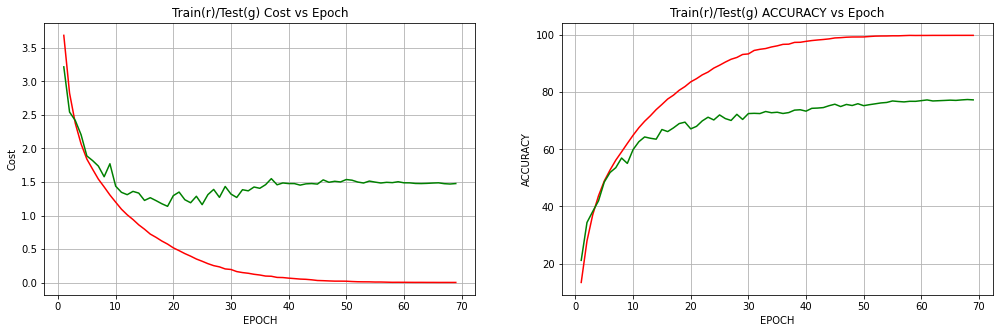

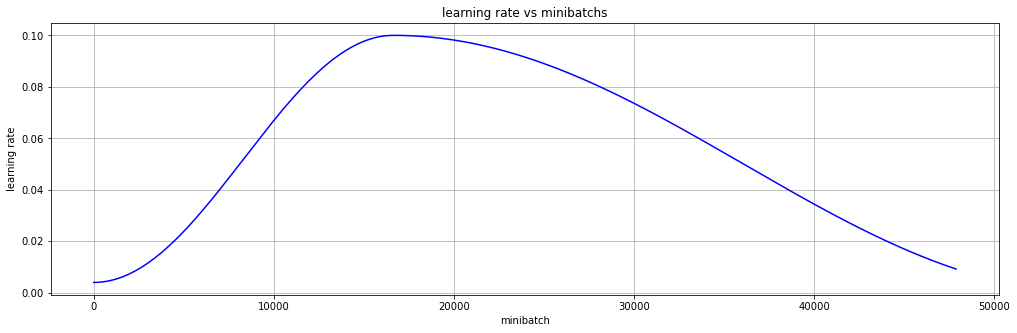

----------------train----------------
Epoch:70/80 batch_idx:230 Train Cost:0.001654
Epoch:70/80 batch_idx:461 Train Cost:0.001644
Epoch:70/80 batch_idx:692 Train Cost:0.001669
Epoch:70/80 batch_idx:693 Train Accuracy:99.886000
----------------test----------------
Epoch:70/80 Test Cost:1.472135 Test Accuracy:77.4200


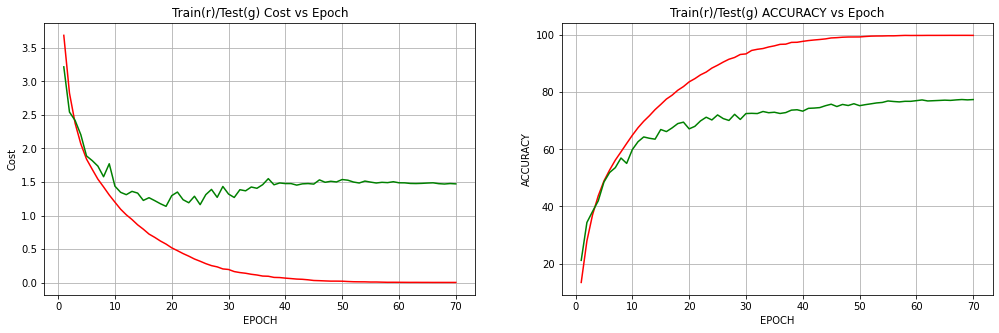

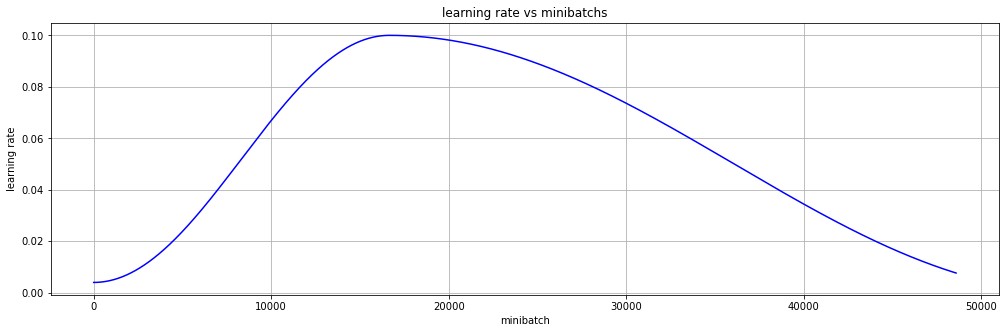

----------------train----------------
Epoch:71/80 batch_idx:230 Train Cost:0.001421
Epoch:71/80 batch_idx:461 Train Cost:0.001639
Epoch:71/80 batch_idx:692 Train Cost:0.001539
Epoch:71/80 batch_idx:693 Train Accuracy:99.892000
----------------test----------------
Epoch:71/80 Test Cost:1.476621 Test Accuracy:77.2200


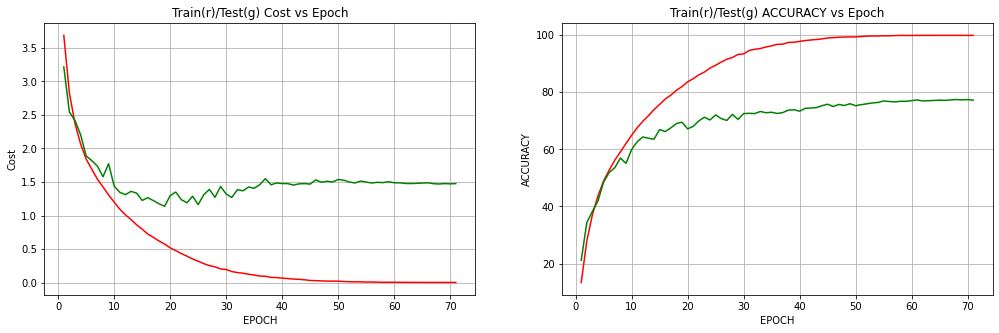

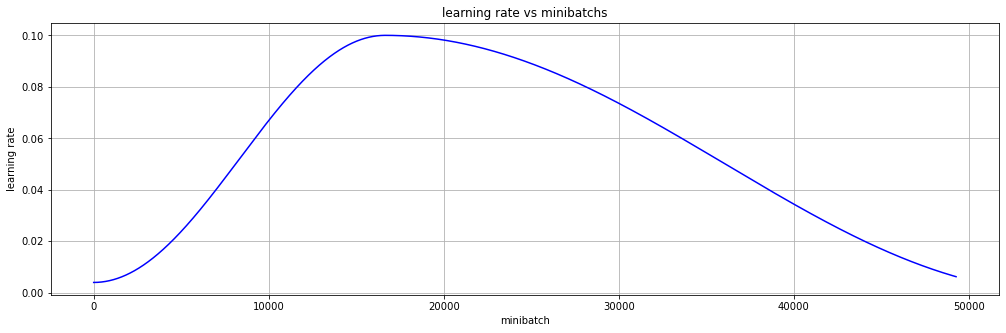

----------------train----------------
Epoch:72/80 batch_idx:230 Train Cost:0.001348
Epoch:72/80 batch_idx:461 Train Cost:0.001466
Epoch:72/80 batch_idx:692 Train Cost:0.001439
Epoch:72/80 batch_idx:693 Train Accuracy:99.902000
----------------test----------------
Epoch:72/80 Test Cost:1.471579 Test Accuracy:77.3800


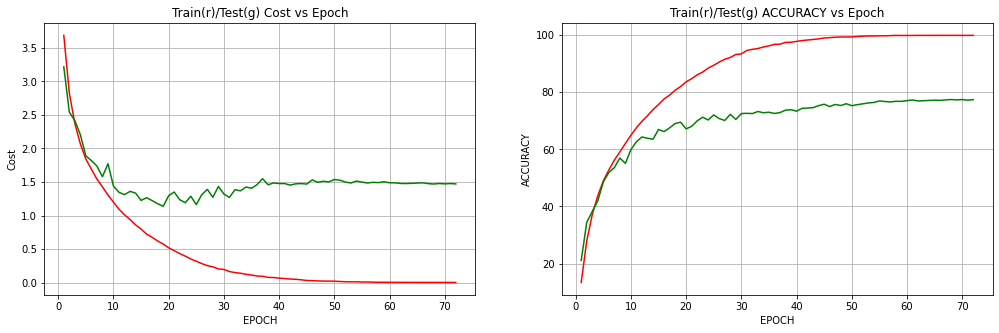

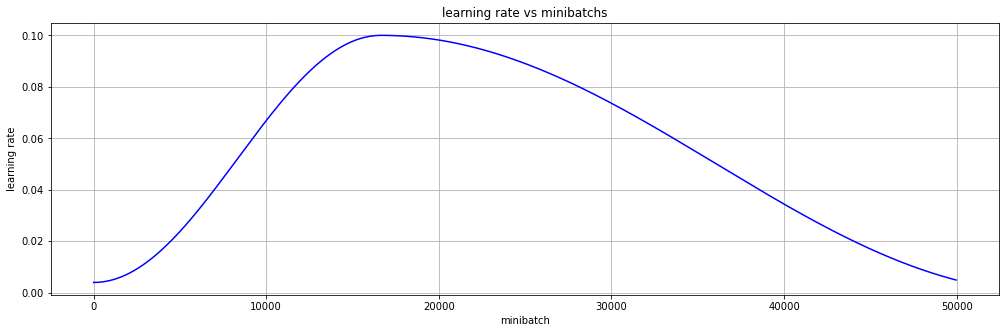

----------------train----------------
Epoch:73/80 batch_idx:230 Train Cost:0.001163
Epoch:73/80 batch_idx:461 Train Cost:0.001102
Epoch:73/80 batch_idx:692 Train Cost:0.001274
Epoch:73/80 batch_idx:693 Train Accuracy:99.912000
----------------test----------------
Epoch:73/80 Test Cost:1.476653 Test Accuracy:77.4300


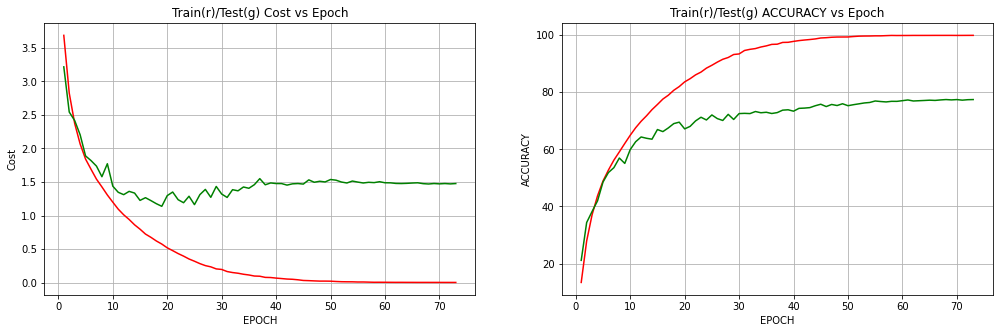

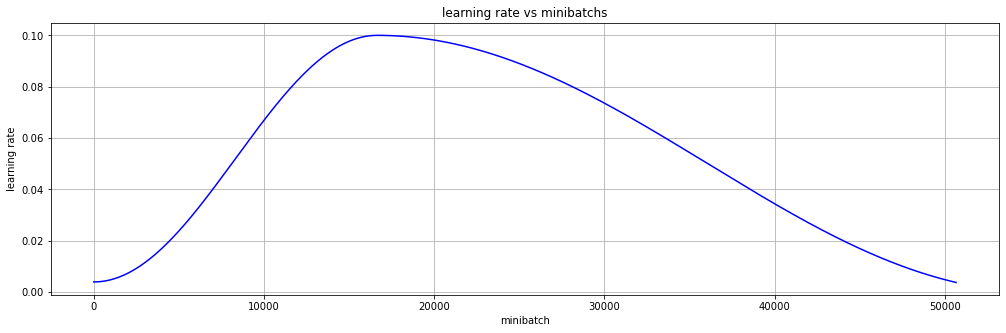

----------------train----------------
Epoch:74/80 batch_idx:230 Train Cost:0.000894
Epoch:74/80 batch_idx:461 Train Cost:0.001135
Epoch:74/80 batch_idx:692 Train Cost:0.001233
Epoch:74/80 batch_idx:693 Train Accuracy:99.914000
----------------test----------------
Epoch:74/80 Test Cost:1.467900 Test Accuracy:77.5500


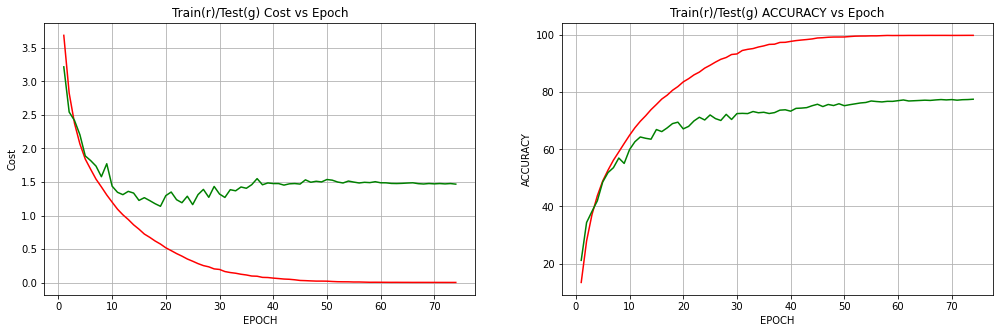

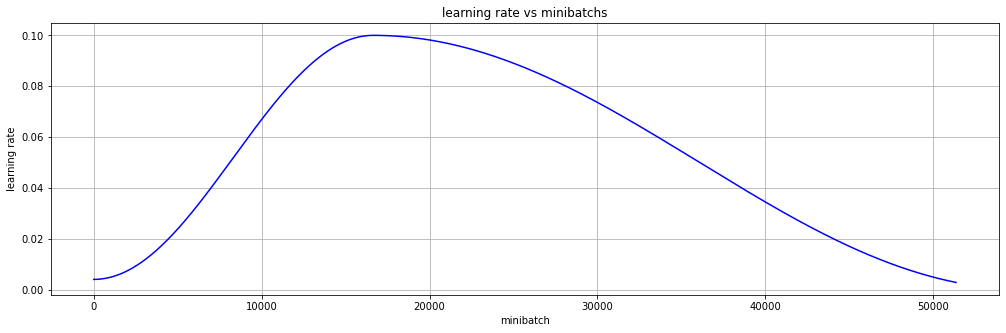

----------------train----------------
Epoch:75/80 batch_idx:230 Train Cost:0.001408
Epoch:75/80 batch_idx:461 Train Cost:0.001099
Epoch:75/80 batch_idx:692 Train Cost:0.001033
Epoch:75/80 batch_idx:693 Train Accuracy:99.918000
----------------test----------------
Epoch:75/80 Test Cost:1.465810 Test Accuracy:77.3300


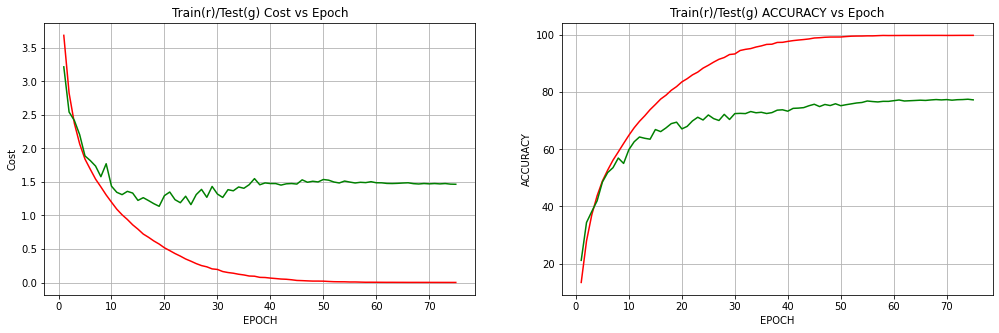

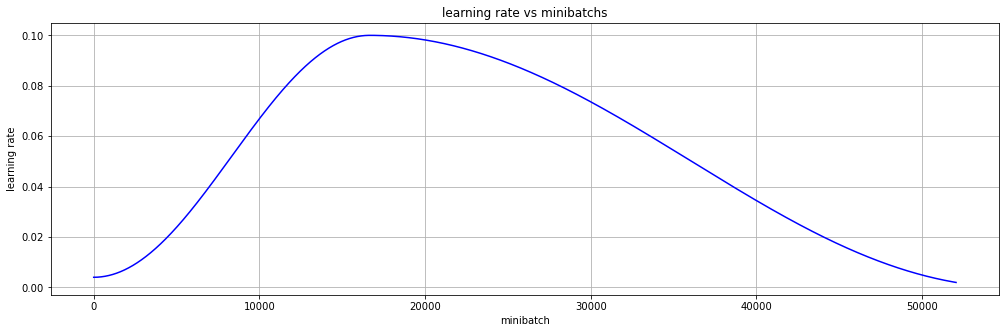

----------------train----------------
Epoch:76/80 batch_idx:230 Train Cost:0.001330
Epoch:76/80 batch_idx:461 Train Cost:0.001307
Epoch:76/80 batch_idx:692 Train Cost:0.001331
Epoch:76/80 batch_idx:693 Train Accuracy:99.904000
----------------test----------------
Epoch:76/80 Test Cost:1.467974 Test Accuracy:77.5500


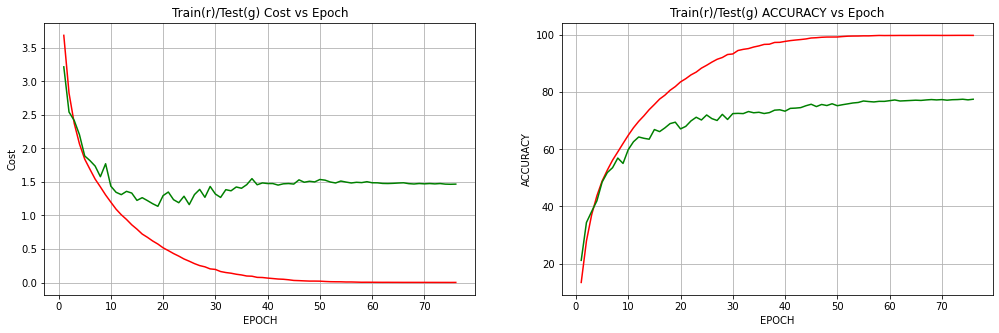

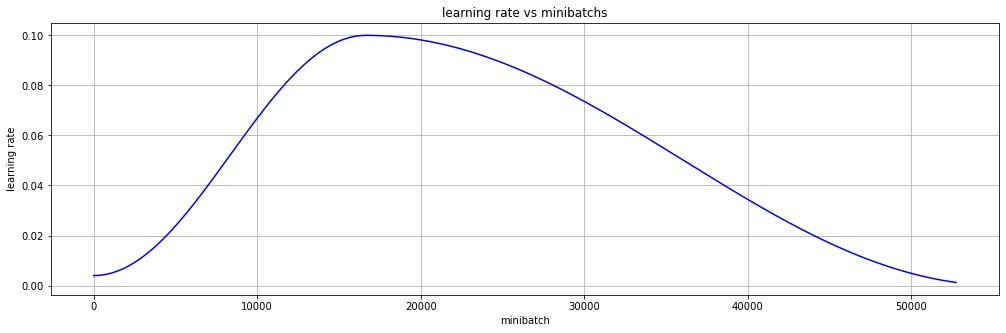

----------------train----------------
Epoch:77/80 batch_idx:230 Train Cost:0.000789
Epoch:77/80 batch_idx:461 Train Cost:0.000950
Epoch:77/80 batch_idx:692 Train Cost:0.000947
Epoch:77/80 batch_idx:693 Train Accuracy:99.922000
----------------test----------------
Epoch:77/80 Test Cost:1.476554 Test Accuracy:77.3700


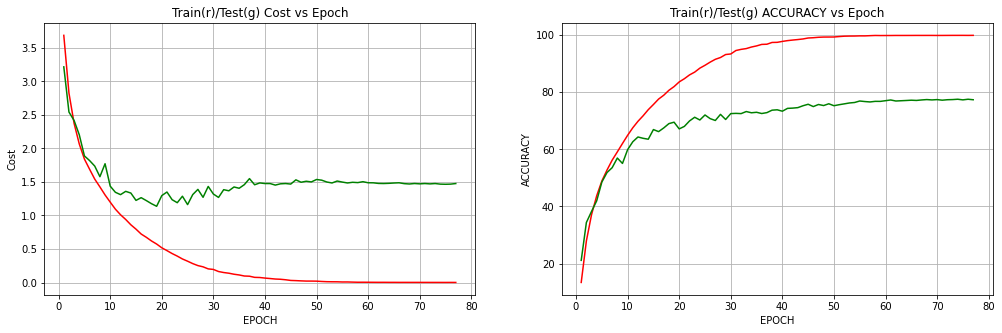

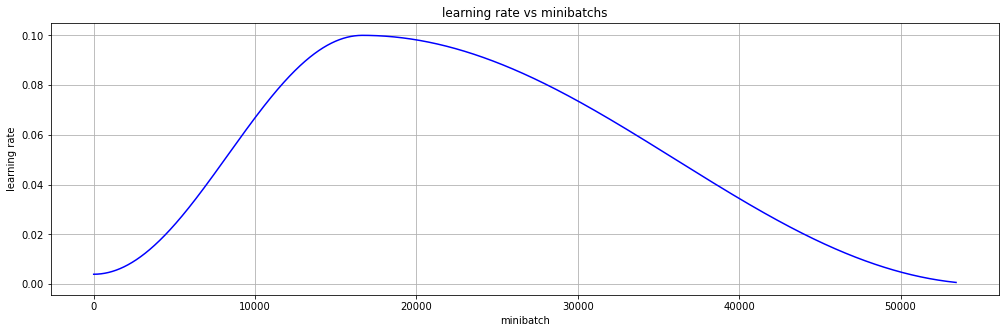

----------------train----------------
Epoch:78/80 batch_idx:230 Train Cost:0.000876
Epoch:78/80 batch_idx:461 Train Cost:0.000936
Epoch:78/80 batch_idx:692 Train Cost:0.001033
Epoch:78/80 batch_idx:693 Train Accuracy:99.918000
----------------test----------------
Epoch:78/80 Test Cost:1.480527 Test Accuracy:77.4400


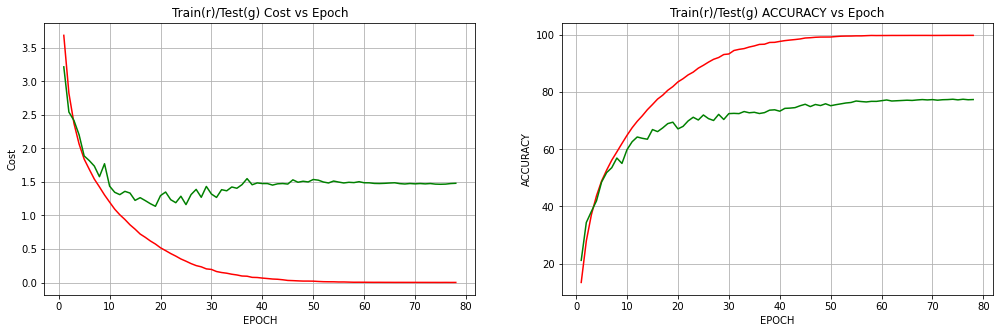

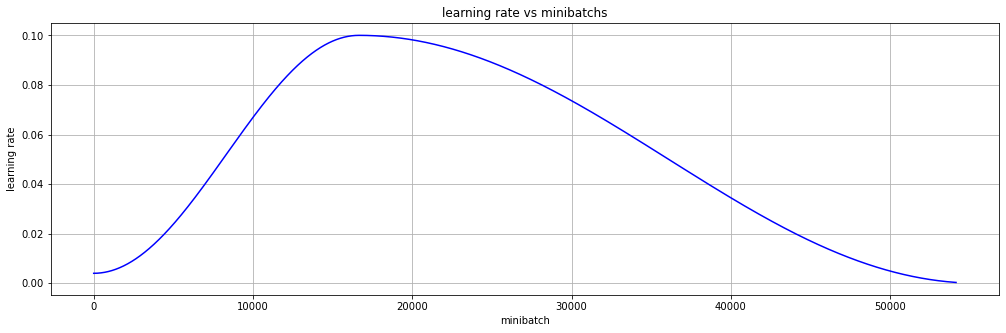

----------------train----------------
Epoch:79/80 batch_idx:230 Train Cost:0.001168
Epoch:79/80 batch_idx:461 Train Cost:0.001230
Epoch:79/80 batch_idx:692 Train Cost:0.001233
Epoch:79/80 batch_idx:693 Train Accuracy:99.910000
----------------test----------------
Epoch:79/80 Test Cost:1.456926 Test Accuracy:77.4900


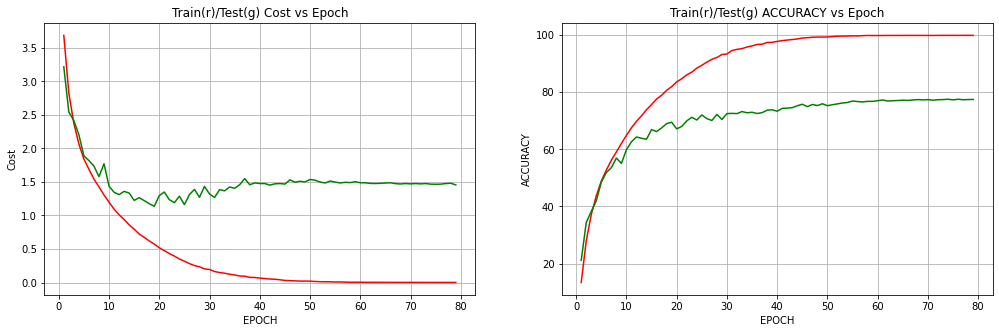

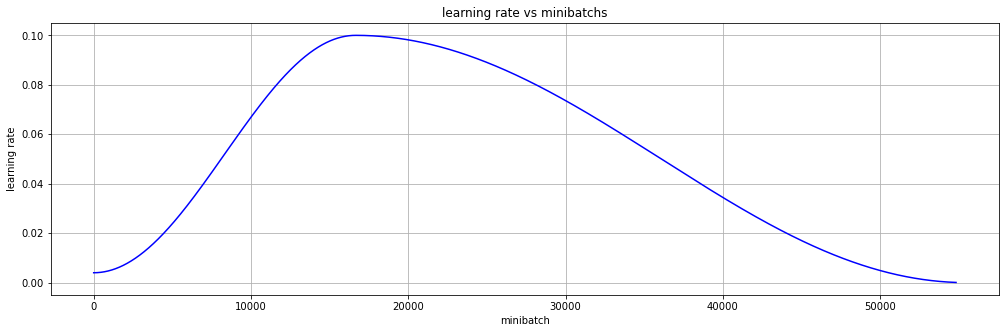

----------------train----------------
Epoch:80/80 batch_idx:230 Train Cost:0.000969
Epoch:80/80 batch_idx:461 Train Cost:0.001238
Epoch:80/80 batch_idx:692 Train Cost:0.001256
Epoch:80/80 batch_idx:693 Train Accuracy:99.912000
----------------test----------------
Epoch:80/80 Test Cost:1.458899 Test Accuracy:77.3400


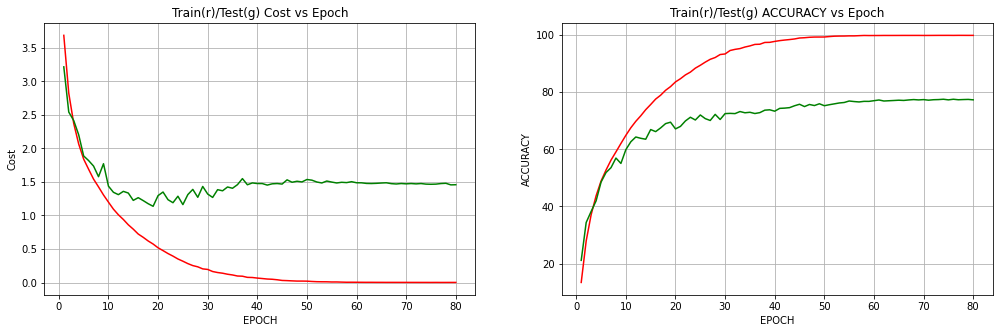

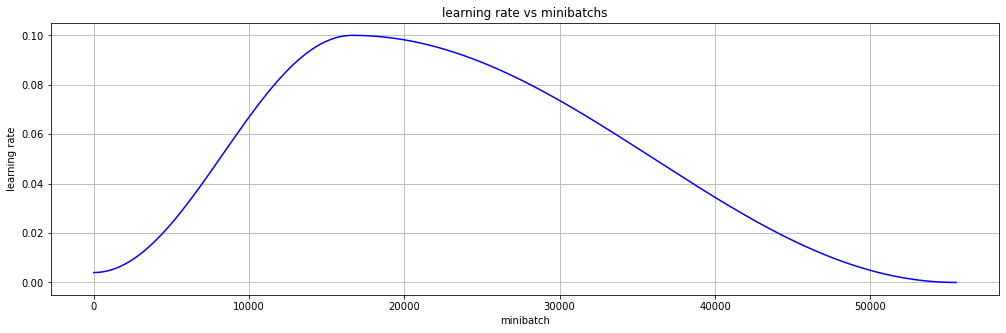

Text(0.5, 1.0, 'learning rate vs minibatchs')

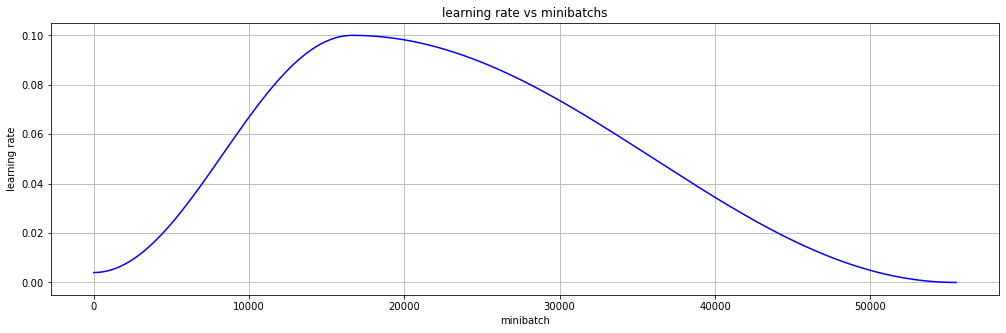

In [17]:
#clear GPU cache
for _ in range(5):
    gc.collect()
    torch.cuda.empty_cache()

DEVICE = 'cuda:3' #smi5
LEARNING_RATE = 0.1
TRAIN_EPOCHS = 80
#models I've tried
# d121 = [6,12,24,16]     accu: 71.67%
# d161 = [6,12,32,32]     accu: 70.29%
# custom = [3, 9, 18]     accu: 72.13%
# custom2 = [5, 10, 20]   accu: 71.58%
# custom3 = [4, 10, 24]   accu: 74.30%
# custom4 = [4, 10, 24]   accu: 75.71% #growth_rate=32
# custom5 = [5, 13, 27]   accu: 76.34%
# custom6 = [6, 15, 29]   accu: 76.24%
# custom7 = [6, 17, 29]   accu: 76.37%
# custom8 = [10, 17, 29]  accu: 76.89%
# custom9 = [12, 19, 30]  accu: 77.22%
custom10 = [15, 23, 30] # accu: 77.85%
nblocks = custom10
gr = 32 
model_densenet = DenseNet(Bottleneck, nblocks, growth_rate=gr) #DenseNet(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100) 
model_densenet = model_densenet.to(DEVICE)

optimizer = optim.SGD(model_densenet.parameters(), lr=LEARNING_RATE, momentum=0.9)
lr_sche = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = LEARNING_RATE, epochs=TRAIN_EPOCHS, steps_per_epoch=len(train_data_loader))

creterion = nn.CrossEntropyLoss().to(DEVICE)

train_cost_arr = []
train_accu_arr = []
test_cost_arr = []
test_accu_arr = []
x_array = []
lr_array = []
str_blocks = '|'.join(map(str, nblocks)) #for saving model informaiton

for epoch in range(TRAIN_EPOCHS):
    x_array.append(epoch + 1)
    train_cost_sum = 0
    test_cost_avg = 0

    model_densenet.train()
    train_model(model_densenet, epoch+1, train_data_loader, optimizer, lr_sche, creterion, train_cost_arr,train_accu_arr, lr_array)
    
    model_densenet.eval()
    test_model(model_densenet, epoch+1, test_data_loader, creterion, test_cost_arr, test_accu_arr)

    
    plt.subplot(1,2,1)
    plt.plot(x_array, train_cost_arr, 'r', label='train cost')
    plt.plot(x_array, test_cost_arr, 'g', label='test cost')
    plt.xlabel('EPOCH')
    plt.ylabel('Cost')
    plt.title('Train(r)/Test(g) Cost vs Epoch')
    
    plt.subplot(1,2,2)
    plt.plot(x_array, train_accu_arr, 'r', label='train accu')
    plt.plot(x_array, test_accu_arr, 'g', label='test accu')
    plt.xlabel('EPOCH')
    plt.ylabel('ACCURACY')
    plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
    
    plt.rcParams["figure.figsize"] = (17,5)
    plt.rcParams['axes.grid'] = True 
    plt.show()

    plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
    plt.xlabel('minibatch')
    plt.ylabel('learning rate')
    plt.title('learning rate vs minibatchs')
    plt.show()

torch.save(model_densenet, '../trained_models/densenet{}_epoch{}_ly{}_gr{}_accuLB{:2.2f}|{:2.2f}.pt'.format(sum(nblocks)*2 + 5 ,TRAIN_EPOCHS, str_blocks, gr, test_accu_arr[-1], max(test_accu_arr)))

plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
plt.xlabel('minibatch')
plt.ylabel('learning rate')
plt.title('learning rate vs minibatchs')

<h4><b><u> Plot final graph

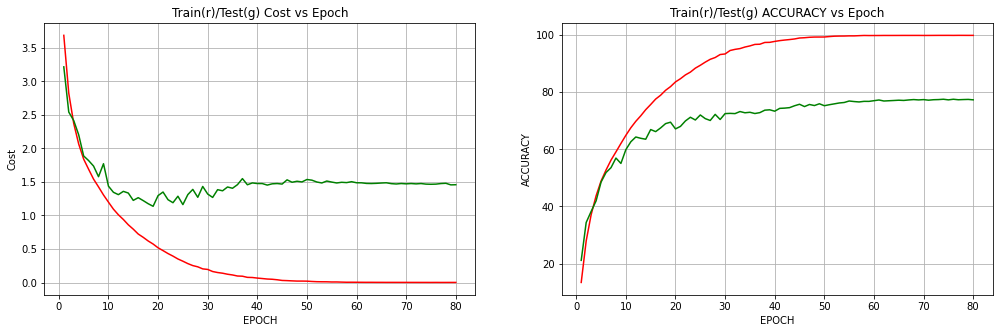

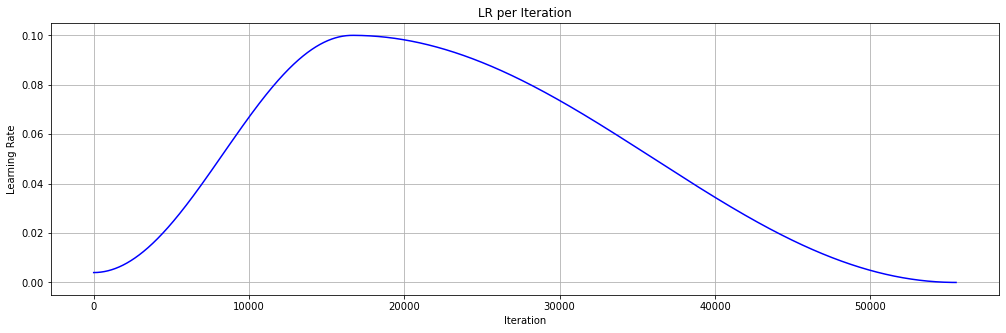

In [22]:
plt.rcParams["figure.figsize"] = (17,5)
plt.rcParams['axes.grid'] = True 

plt.subplot(1,2,1)
plt.plot(x_array, train_cost_arr, 'r', label='train cost')
plt.plot(x_array, test_cost_arr, 'g', label='test cost')
plt.xlabel('EPOCH')
plt.ylabel('Cost')
plt.title('Train(r)/Test(g) Cost vs Epoch')

plt.subplot(1,2,2)
plt.plot(x_array, train_accu_arr, 'r', label='train accu')
plt.plot(x_array, test_accu_arr, 'g', label='test accu')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
plt.show()

plt.plot([x for x in range(len(lr_array))], lr_array, 'b', label='lr per iteration')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('LR per Iteration')
plt.show()

<h4><b><u> Codes for testing model with no graph.

In [3]:
DEVICE = 'cuda:5'
creterion = nn.CrossEntropyLoss().to(DEVICE)

def test_model_no_graph(_model, _test_data, _creterion):
    test_cost = 0
    test_accu = 0
    corrects = 0
    _model.to(DEVICE)
    _model.eval()
    print('----------------test----------------')
    for data in _test_data:
        x, y = data
        x = x.float().to(DEVICE)
        y = torch.Tensor(y)
        y = y.to(DEVICE)
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        # cost = _creterion(prediction, y).item()
        # test_cost += cost/len(test_data_loader)
        test_accu += corrects / len(test_data)

    return test_cost, test_accu

model_loaded = torch.load('../trained_models/densenet141_epoch80_ly15|23|30_gr32_accuLB77.34|77.55.pt')    
model_loaded = model_loaded.to(DEVICE)
test_cost, test_accuracy = test_model_no_graph(model_loaded, test_data_loader, creterion)
print('Test Cost: ', test_cost, '\nTest Accuracy', test_accuracy)

AttributeError: Can't get attribute 'DenseNet' on <module '__main__'>

In [15]:
DEVICE = 'cuda:3'

def test_model_no_graph(_model, _test_data):
    test_cost = 0
    test_accu = 0
    corrects = 0
    _model.to(DEVICE)
    _model.eval()
    print('----------------test----------------')
    # for data in _test_data:
    x, y = _test_data
    print(x.shape)
    x = x.float().to(DEVICE)
    print(type(y))
    y = y.float().to(DEVICE)
    prediction = _model(x)
    print(prediction.shape)
    corrects += (prediction.argmax(1) == y).sum().item()
    # cost = _creterion(prediction, y).item()
    # test_cost += cost/len(test_data_loader)
    test_accu += corrects / len(test_data)

    # return test_cost, test_accu

model_loaded = torch.load('../trained_models/densenet141_epoch80_ly15|23|30_gr32_accuLB77.34|77.55.pt')    
model_loaded = model_loaded.to(DEVICE)
test_cost, test_accuracy = test_model_no_graph(model_loaded, test_data)
print('Test Cost: ', test_cost, '\nTest Accuracy', test_accuracy)

----------------test----------------


ValueError: too many values to unpack (expected 2)

<h3> <u> <b> Clear GPU

In [44]:
#I recommand to restart kernel
#The codes below is the next best thing.

gc.collect()
torch.cuda.empty_cache()